<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Bias-mitigation-Kiva-Dataset" data-toc-modified-id="Bias-mitigation-Kiva-Dataset-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Bias mitigation Kiva Dataset</a></span><ul class="toc-item"><li><span><a href="#Pre-processing-the-data" data-toc-modified-id="Pre-processing-the-data-1.1"><span class="toc-item-num">1.1&nbsp;&nbsp;</span>Pre-processing the data</a></span></li><li><span><a href="#Transform-to-AIF360-dataset" data-toc-modified-id="Transform-to-AIF360-dataset-1.2"><span class="toc-item-num">1.2&nbsp;&nbsp;</span>Transform to AIF360 dataset</a></span></li><li><span><a href="#Original-XGBoost-model" data-toc-modified-id="Original-XGBoost-model-1.3"><span class="toc-item-num">1.3&nbsp;&nbsp;</span>Original XGBoost model</a></span><ul class="toc-item"><li><span><a href="#SHAP-baseline" data-toc-modified-id="SHAP-baseline-1.3.1"><span class="toc-item-num">1.3.1&nbsp;&nbsp;</span>SHAP baseline</a></span></li></ul></li><li><span><a href="#Bias-detection-with-AIF360" data-toc-modified-id="Bias-detection-with-AIF360-1.4"><span class="toc-item-num">1.4&nbsp;&nbsp;</span>Bias detection with AIF360</a></span></li><li><span><a href="#Bias-mitigation-with-AIF360-algorithms" data-toc-modified-id="Bias-mitigation-with-AIF360-algorithms-1.5"><span class="toc-item-num">1.5&nbsp;&nbsp;</span>Bias mitigation with AIF360 algorithms</a></span><ul class="toc-item"><li><span><a href="#Pre-processing" data-toc-modified-id="Pre-processing-1.5.1"><span class="toc-item-num">1.5.1&nbsp;&nbsp;</span>Pre-processing</a></span></li><li><span><a href="#In-processing" data-toc-modified-id="In-processing-1.5.2"><span class="toc-item-num">1.5.2&nbsp;&nbsp;</span>In-processing</a></span></li><li><span><a href="#Post-processing" data-toc-modified-id="Post-processing-1.5.3"><span class="toc-item-num">1.5.3&nbsp;&nbsp;</span>Post-processing</a></span></li></ul></li><li><span><a href="#Compare-fairness-metrics-and-accuracy" data-toc-modified-id="Compare-fairness-metrics-and-accuracy-1.6"><span class="toc-item-num">1.6&nbsp;&nbsp;</span>Compare fairness metrics and accuracy</a></span></li><li><span><a href="#Check-the-best-models" data-toc-modified-id="Check-the-best-models-1.7"><span class="toc-item-num">1.7&nbsp;&nbsp;</span>Check the best models</a></span><ul class="toc-item"><li><span><a href="#Reweighing" data-toc-modified-id="Reweighing-1.7.1"><span class="toc-item-num">1.7.1&nbsp;&nbsp;</span>Reweighing</a></span><ul class="toc-item"><li><span><a href="#SHAP-reweighing" data-toc-modified-id="SHAP-reweighing-1.7.1.1"><span class="toc-item-num">1.7.1.1&nbsp;&nbsp;</span>SHAP reweighing</a></span></li></ul></li><li><span><a href="#Equality-of-odds" data-toc-modified-id="Equality-of-odds-1.7.2"><span class="toc-item-num">1.7.2&nbsp;&nbsp;</span>Equality of odds</a></span></li><li><span><a href="#LFR" data-toc-modified-id="LFR-1.7.3"><span class="toc-item-num">1.7.3&nbsp;&nbsp;</span>LFR</a></span><ul class="toc-item"><li><span><a href="#SHAP-LFR" data-toc-modified-id="SHAP-LFR-1.7.3.1"><span class="toc-item-num">1.7.3.1&nbsp;&nbsp;</span>SHAP LFR</a></span></li></ul></li></ul></li></ul></li></ul></div>

# Bias mitigation Kiva Dataset

This notebook builds a ML classifier on the Kiva dataset to predict the status of a loan. Several bias detection metrics will be applied to investigate biases. When a bias is detected, we can apply fairness algorithms of the AIF360 library to mitigate the bias. We start from a sample of the original Kiva dataset. This sample is constructed with a down-sampling technique to balance the dataset. The outline of the notebook is as follows:
   - 1) Transforming the sample to a AIF360 dataset
   
   - 2) Building an original model with XGBoost
   
   - 3) Bias detection on the original model
   
   - 4) Fix biases with AIF360 fairness algorithms
   
   - 5) Compare fairness and accuracy scores for all models
   
   - 6) Investigate the best models

## Pre-processing the data

In [1]:
# data manipulation libraries
import pandas as pd
import numpy as np

from time import time

# Graphs libraries
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.patches as patches
plt.style.use('seaborn-white')
import seaborn as sns

import plotly.offline as py
py.init_notebook_mode(connected=True)
import plotly.graph_objs as go
import plotly.tools as tls
import plotly.figure_factory as ff
from plotly import tools

# Libraries to study
from aif360.datasets import StandardDataset, BinaryLabelDataset
from aif360.metrics import BinaryLabelDatasetMetric, ClassificationMetric
from aif360.algorithms.preprocessing import LFR, Reweighing
from aif360.algorithms.inprocessing import AdversarialDebiasing, PrejudiceRemover
from aif360.algorithms.postprocessing import CalibratedEqOddsPostprocessing, EqOddsPostprocessing, RejectOptionClassification

# ML libraries
from sklearn.metrics import confusion_matrix, accuracy_score, f1_score, roc_curve, auc, recall_score, precision_score
from sklearn.preprocessing import MinMaxScaler, LabelEncoder, OneHotEncoder
from sklearn.ensemble import RandomForestClassifier
import tensorflow as tf

# Design libraries
from IPython.display import Markdown, display
import warnings
warnings.filterwarnings("ignore")

In [2]:
import shap
# print the JS visualization code to the notebook
shap.initjs()

In [3]:
merge1 = pd.read_csv(r"C:\Users\peter\Documents\2e master HIR\Thesis Kiva\merge1_final_corrected.csv",index_col=None)

In [4]:
merge1.head()

loan_id original_language  loan_amount  status    activity_name  \
0  1000994           English        100.0  funded  Home Appliances   
1   992398           English        600.0  funded            Dairy   
2  1004416           English        275.0  funded          Farming   
3  1335488           English        600.0  funded          Farming   
4   796409           English        125.0  funded            Hotel   

    sector_name country_name  partner_id repayment_interval  \
0  Personal Use     Cambodia       311.0            monthly   
1   Agriculture        Kenya       388.0            monthly   
2   Agriculture  Philippines       145.0          irregular   
3   Agriculture  Philippines       123.0             bullet   
4      Services        Kenya       388.0            monthly   

  distribution_model  year  month  \
0      field_partner  2015     12   
1      field_partner  2015     12   
2      field_partner  2016      1   
3      field_partner  2017      7   
4      field_partner  2014     11   

                                     description_ENG  borrower_count  \
0  Morn’s group lives in a rural village in Kampo...             2.0   
1  The gentleman raising his hand in the photo is...             3.0   
2  Wilma is already 55 years old and is married w...             1.0   
3  Melanio is 47 years old, married, and has two ...             1.0   
4  This is Margaret, forty-five years old and a m...             1.0   

    loan_type gender_reclassified dominant_topic Loan Theme Type  \
0       group                male  Providing_use           Water   
1       group                male   Clothing_use         Startup   
2  individual              female    Farming_use         General   
3  individual                male    Farming_use         General   
4  individual              female      Stock_use         Startup   

                world_region   MPI  
0  East Asia and the Pacific  0.16  
1         Sub-Saharan Africa  0.21  
2  East Asia and the Pacific  0.06  
3  East Asia and the Pacific  0.06  
4         Sub-Saharan Africa  0.21

In [5]:
merge1['status'].value_counts()

expired    34969
funded     34969
Name: status, dtype: int64

In [6]:
merge1['partner_id'] = merge1['partner_id'].astype('category')
merge1['year'] = merge1['year'].astype('category')
merge1['month'] = merge1['month'].astype('category')

In [7]:
#del merge1['Loan Theme Type']
#del merge1['activity_name']
#del merge1['dominant_topic']

In [8]:
del merge1['distribution_model']
del merge1['year']

In [9]:
merge1['status'] = np.where(merge1['status'] =='funded', 1, 0)

**Binning numerical features**

   - **Quantile-based binning**: Cuts the variable into roughly equal groups using quantiles.

Text(0, 0.5, 'Frequency')

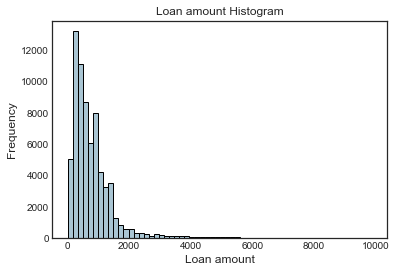

In [10]:
fig, ax = plt.subplots()
merge1['loan_amount'][merge1['loan_amount']<10000].hist(bins=60, color='#A9C5D3', 
                             edgecolor='black', grid=False)
ax.set_title('Loan amount Histogram', fontsize=12)
ax.set_xlabel('Loan amount', fontsize=12)
ax.set_ylabel('Frequency', fontsize=12)

In [11]:
quantile_list = [0, .05, .1, .15, .2, .25, .3, .35, .4, .45, .5,
                .55, .6, .65, .7, .75, .8, .85, .9, .95, 1.0]
quantiles = merge1['loan_amount'].quantile(quantile_list)
quantiles

0.00       25.0
0.05      150.0
0.10      200.0
0.15      250.0
0.20      300.0
0.25      350.0
0.30      400.0
0.35      475.0
0.40      500.0
0.45      550.0
0.50      625.0
0.55      700.0
0.60      800.0
0.65      900.0
0.70     1000.0
0.75     1025.0
0.80     1150.0
0.85     1325.0
0.90     1500.0
0.95     2200.0
1.00    50000.0
Name: loan_amount, dtype: float64

In [12]:
quantile_labels = ['0-5Q', '5-10Q', '10-15Q', '15-20Q','20-25Q', '25-30Q', '30-35Q', '35-40Q',
                  '40-45Q', '45-50Q', '50-55Q', '55-60Q','60-65Q', '65-70Q', '70-75Q', '75-80Q',
                  '80-85Q', '85-90Q', '90-95Q', '95-100Q']
merge1['loan_amount_range'] = pd.qcut(
                                            merge1['loan_amount'], 
                                            q=quantile_list)
merge1['loan_amount_bin'] = pd.qcut(
                                            merge1['loan_amount'], 
                                            q=quantile_list,       
                                            labels=quantile_labels)

merge1.head()

loan_id original_language  loan_amount  status    activity_name  \
0  1000994           English        100.0       1  Home Appliances   
1   992398           English        600.0       1            Dairy   
2  1004416           English        275.0       1          Farming   
3  1335488           English        600.0       1          Farming   
4   796409           English        125.0       1            Hotel   

    sector_name country_name partner_id repayment_interval month  \
0  Personal Use     Cambodia      311.0            monthly    12   
1   Agriculture        Kenya      388.0            monthly    12   
2   Agriculture  Philippines      145.0          irregular     1   
3   Agriculture  Philippines      123.0             bullet     7   
4      Services        Kenya      388.0            monthly    11   

                                     description_ENG  borrower_count  \
0  Morn’s group lives in a rural village in Kampo...             2.0   
1  The gentleman raising his hand in the photo is...             3.0   
2  Wilma is already 55 years old and is married w...             1.0   
3  Melanio is 47 years old, married, and has two ...             1.0   
4  This is Margaret, forty-five years old and a m...             1.0   

    loan_type gender_reclassified dominant_topic Loan Theme Type  \
0       group                male  Providing_use           Water   
1       group                male   Clothing_use         Startup   
2  individual              female    Farming_use         General   
3  individual                male    Farming_use         General   
4  individual              female      Stock_use         Startup   

                world_region   MPI loan_amount_range loan_amount_bin  
0  East Asia and the Pacific  0.16   (24.999, 150.0]            0-5Q  
1         Sub-Saharan Africa  0.21    (550.0, 625.0]          45-50Q  
2  East Asia and the Pacific  0.06    (250.0, 300.0]          15-20Q  
3  East Asia and the Pacific  0.06    (550.0, 625.0]          45-50Q  
4         Sub-Saharan Africa  0.21   (24.999, 150.0]            0-5Q

In [13]:
merge1.loan_amount_bin.value_counts()

65-70Q     5744
45-50Q     4180
35-40Q     4133
15-20Q     4093
55-60Q     3983
50-55Q     3971
0-5Q       3824
10-15Q     3715
85-90Q     3497
25-30Q     3486
30-35Q     3479
90-95Q     3448
95-100Q    3446
75-80Q     3373
20-25Q     3364
5-10Q      3272
80-85Q     3249
60-65Q     2668
40-45Q     2155
70-75Q      858
Name: loan_amount_bin, dtype: int64

In [14]:
#del merge1['loan_amount']
#del merge1['loan_amount_range']

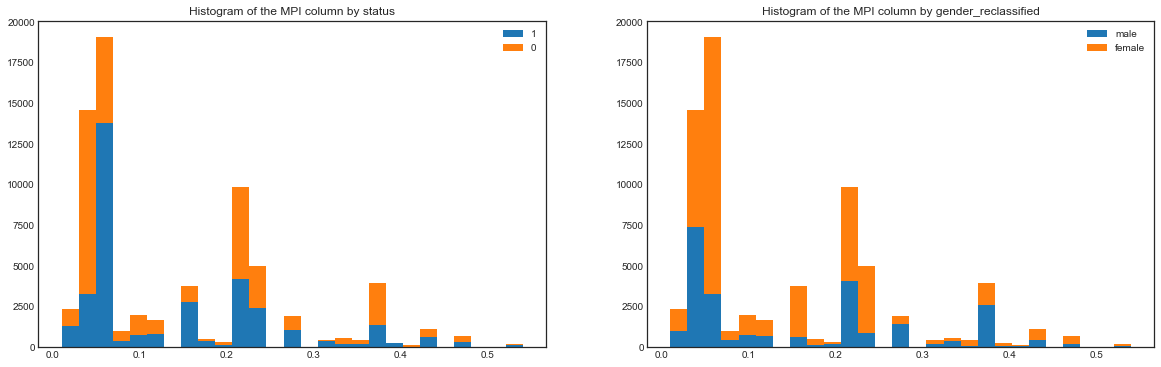

In [14]:
def plot_histo(data, col, Y_columns):
    df = data.copy()
    fig, axs = plt.subplots(1,2,figsize=(20,6))
    
    for i in range(0,2):
        cnt = []; y_col = Y_columns[i]
        Y_values = df[y_col].dropna().drop_duplicates().values
        for val in Y_values:
            cnt += [df[df[y_col] == val][col].values]
        bins = df[col].nunique()

        axs[i].hist(cnt, bins=bins, stacked=True)
        axs[i].legend(Y_values,loc='upper right')
        axs[i].set_title("Histogram of the "+col+" column by "+y_col)

    plt.show()
    
target_variable = ['status','gender_reclassified']
plot_histo(merge1, col='MPI',Y_columns=target_variable)

- **Quantile-based binning** with two quantiles based on the median for the variable MPI.
- Label bins 'poor' and 'rich'

In [15]:
merge1['MPI'].describe()

count    69938.000000
mean         0.136908
std          0.119107
min          0.010000
25%          0.050000
50%          0.060000
75%          0.210000
max          0.540000
Name: MPI, dtype: float64

Text(0, 0.5, 'Frequency')

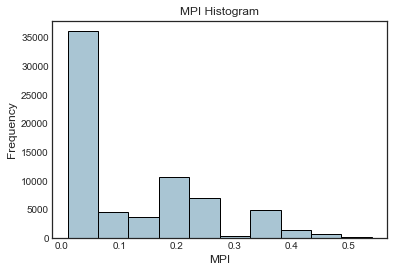

In [16]:
fig, ax = plt.subplots()
merge1['MPI'].hist(bins=10, color='#A9C5D3', 
                             edgecolor='black', grid=False)
ax.set_title('MPI Histogram', fontsize=12)
ax.set_xlabel('MPI', fontsize=12)
ax.set_ylabel('Frequency', fontsize=12)

In [17]:
merge1['MPI category'] = np.where(merge1['MPI'] > 0.06, 'poor', 'rich')
merge1['MPI category'] = np.where(merge1['MPI category'] == 'rich', 1, 0)

In [18]:
merge1.groupby(['MPI category','status']).size()

MPI category  status
0             0         17309
              1         16567
1             0         17660
              1         18402
dtype: int64

The variable **MPI category** has been tested on unfairness but the fairness metrics showed no unfairness.

In [19]:
#Visualisations

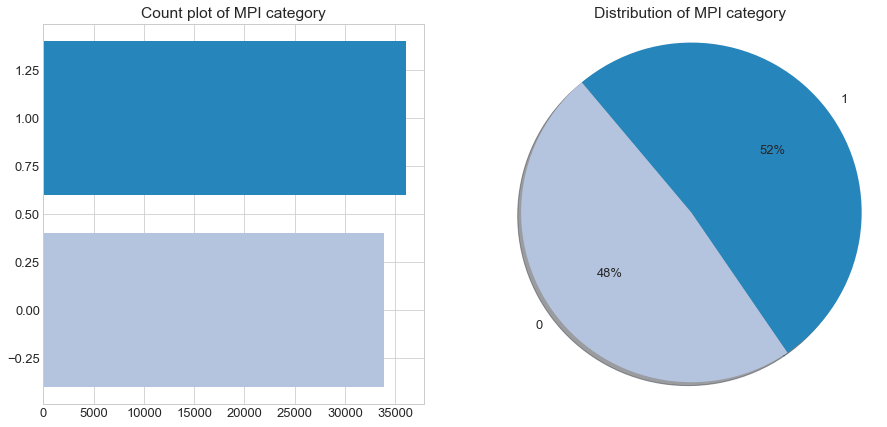

In [20]:
def target_distribution(y_var, data):
    val = data[y_var]

    plt.style.use('seaborn-whitegrid')
    plt.rcParams.update({'font.size': 13})
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 7))

    cnt = val.value_counts().sort_values(ascending=True)
    labels = cnt.index.values

    sizes = cnt.values
    colors = sns.color_palette("PuBu", len(labels))

    #------------COUNT-----------------------
    ax1.barh(cnt.index.values, cnt.values, color=colors)
    ax1.set_title('Count plot of '+y_var)

    #------------PERCENTAGE-------------------
    ax2.pie(sizes, labels=labels, colors=colors,autopct='%1.0f%%', shadow=True, startangle=130)
    ax2.axis('equal')
    ax2.set_title('Distribution of '+y_var)
    plt.show()
    
var = 'MPI category'
target_distribution(y_var=var, data=merge1)

## Transform to AIF360 dataset

In [15]:
data_encoded = pd.concat([merge1[['status']], pd.get_dummies(merge1[['gender_reclassified', 'sector_name','loan_type','world_region','repayment_interval','month','loan_amount_bin']])], axis=1)

Construct a **BinaryLabelDataset**

In [16]:
data_orig_sex = BinaryLabelDataset(df=data_encoded.drop('gender_reclassified_male', axis=1), label_names=['status'], protected_attribute_names=['gender_reclassified_female'])

In [17]:
data_orig_sex

               instance weights                   features  \
                                       protected attribute   
                                gender_reclassified_female   
instance names                                               
0                           1.0                        0.0   
1                           1.0                        0.0   
2                           1.0                        1.0   
3                           1.0                        0.0   
4                           1.0                        1.0   
...                         ...                        ...   
69933                       1.0                        0.0   
69934                       1.0                        1.0   
69935                       1.0                        1.0   
69936                       1.0                        1.0   
69937                       1.0                        1.0   

                                                                     

In [18]:
def meta_data(dataset):
    # print out some labels, names, etc.
    display(Markdown("#### Dataset shape"))
    print(dataset.features.shape)
    display(Markdown("#### Favorable and unfavorable labels"))
    print(dataset.favorable_label, dataset.unfavorable_label)
    display(Markdown("#### Protected attribute names"))
    print(dataset.protected_attribute_names)
    display(Markdown("#### Privileged and unprivileged protected attribute values"))
    print(dataset.privileged_protected_attributes, dataset.unprivileged_protected_attributes)
    display(Markdown("#### Dataset feature names"))
    print(dataset.feature_names)

In [19]:
meta_data(data_orig_sex)

#### Dataset shape

(69938, 59)


#### Favorable and unfavorable labels

1.0 0.0


#### Protected attribute names

['gender_reclassified_female']


#### Privileged and unprivileged protected attribute values

[array([1.])] [array([0.])]


#### Dataset feature names

['gender_reclassified_female', 'sector_name_Agriculture', 'sector_name_Arts', 'sector_name_Clothing', 'sector_name_Construction', 'sector_name_Education', 'sector_name_Entertainment', 'sector_name_Food', 'sector_name_Health', 'sector_name_Housing', 'sector_name_Manufacturing', 'sector_name_Personal Use', 'sector_name_Retail', 'sector_name_Services', 'sector_name_Transportation', 'sector_name_Wholesale', 'loan_type_group', 'loan_type_individual', 'world_region_Arab States', 'world_region_East Asia and the Pacific', 'world_region_Europe and Central Asia', 'world_region_Latin America and Caribbean', 'world_region_South Asia', 'world_region_Sub-Saharan Africa', 'repayment_interval_bullet', 'repayment_interval_irregular', 'repayment_interval_monthly', 'month_1', 'month_2', 'month_3', 'month_4', 'month_5', 'month_6', 'month_7', 'month_8', 'month_9', 'month_10', 'month_11', 'month_12', 'loan_amount_bin_0-5Q', 'loan_amount_bin_5-10Q', 'loan_amount_bin_10-15Q', 'loan_amount_bin_15-20Q', 'loan_a

In [20]:
#Split into train and test set

In [21]:
data_orig_sex_train, data_orig_sex_test = data_orig_sex.split([0.7], shuffle=True, seed=74)

display(Markdown("#### Train Dataset shape"))
print("target_variable :",data_orig_sex_train.features.shape)
display(Markdown("#### Test Dataset shape"))
print("target_variable :",data_orig_sex_test.features.shape)

#### Train Dataset shape

target_variable : (48956, 59)


#### Test Dataset shape

target_variable : (20982, 59)


In [22]:
#training the model: XGBoost

In [23]:
# Train and save the models
import xgboost as xgb
xg_reg = xgb.XGBClassifier(objective ='binary:logistic', colsample_bytree = 0.3, learning_rate = 0.1,
                max_depth = 4, alpha = 10, n_estimators = 10)

xg_orig_sex = xg_reg.fit(data_orig_sex_train.features, 
                     data_orig_sex_train.labels.ravel(), 
                     sample_weight=data_orig_sex_train.instance_weights)

In [24]:
#predict on test set

In [25]:
X_test_sex = data_orig_sex_test.features
y_test_sex = data_orig_sex_test.labels.ravel()

## Original XGBoost model

In [26]:
#Performance of the model

In [74]:
def get_model_performance(X_test, y_true, y_pred, probs):
    accuracy = accuracy_score(y_true, y_pred)
    matrix = confusion_matrix(y_true, y_pred)
    f1 = f1_score(y_true, y_pred)
    recall = recall_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred)
    preds = probs[:, 1]
    fpr, tpr, threshold = roc_curve(y_true, preds)
    roc_auc = auc(fpr, tpr)

    return accuracy, matrix, f1, fpr, tpr, roc_auc, recall, precision

def plot_model_performance(model, X_test, y_true):
    y_pred = model.predict(X_test)
    probs = model.predict_proba(X_test)
    accuracy, matrix, f1, fpr, tpr, roc_auc = get_model_performance(X_test, y_true, y_pred, probs)

    display(Markdown('#### Accuracy of the model :'))
    print(accuracy)
    display(Markdown('#### F1 score of the model :'))
    print(f1)

    fig = plt.figure(figsize=(15, 6))
    ax = fig.add_subplot(1, 2, 1)
    sns.heatmap(matrix, annot=True, cmap='Blues', fmt='g')
    ax.set_ylim([0,2])
    plt.title('Confusion Matrix')

    ax = fig.add_subplot(1, 2, 2)
    
    lw = 2
    plt.plot(fpr, tpr, color='darkorange', lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic curve')
    plt.legend(loc="lower right")

#### Accuracy of the model :

0.7493565913640263


#### F1 score of the model :

0.717212453621552


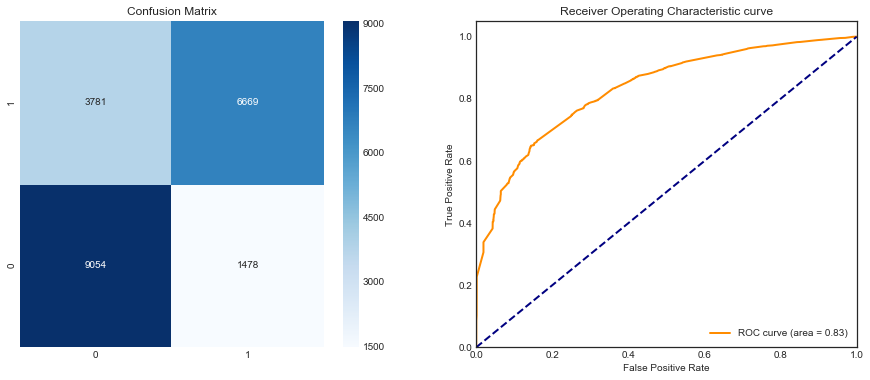

In [28]:
plot_model_performance(xg_orig_sex, data_orig_sex_test.features, y_test_sex)

In [34]:
import os
os.environ["PATH"] += os.pathsep + 'C:\\Program Files (x86)\\Graphviz\\bin\\'

In [35]:
df = data_orig_sex_train.convert_to_dataframe(de_dummy_code=False, sep='=', set_category=True)
df_train = df[0].copy()
df1 = data_orig_sex_test.convert_to_dataframe(de_dummy_code=False, sep='=', set_category=True)
df_test = df1[0].copy()




xg_orig = xgb.XGBClassifier(objective ='binary:logistic', colsample_bytree = 0.3, learning_rate = 0.1,
                max_depth = 4, alpha = 10, n_estimators = 10)

y_train= df_train['status']
X_train= df_train.drop('status',axis=1)
xg_orig = xg_orig.fit(X_train,y_train)

y_test= df_test['status']
X_test= df_test.drop('status',axis=1)
probs = xg_orig.predict_proba(X_test)
preds = xg_orig.predict(X_test)

from sklearn.metrics import accuracy_score
# evaluate predictions
accuracy = accuracy_score(y_test, preds)
print("Accuracy: %.2f%%" % (accuracy * 100.0))

Accuracy: 74.94%


**Decision tree**

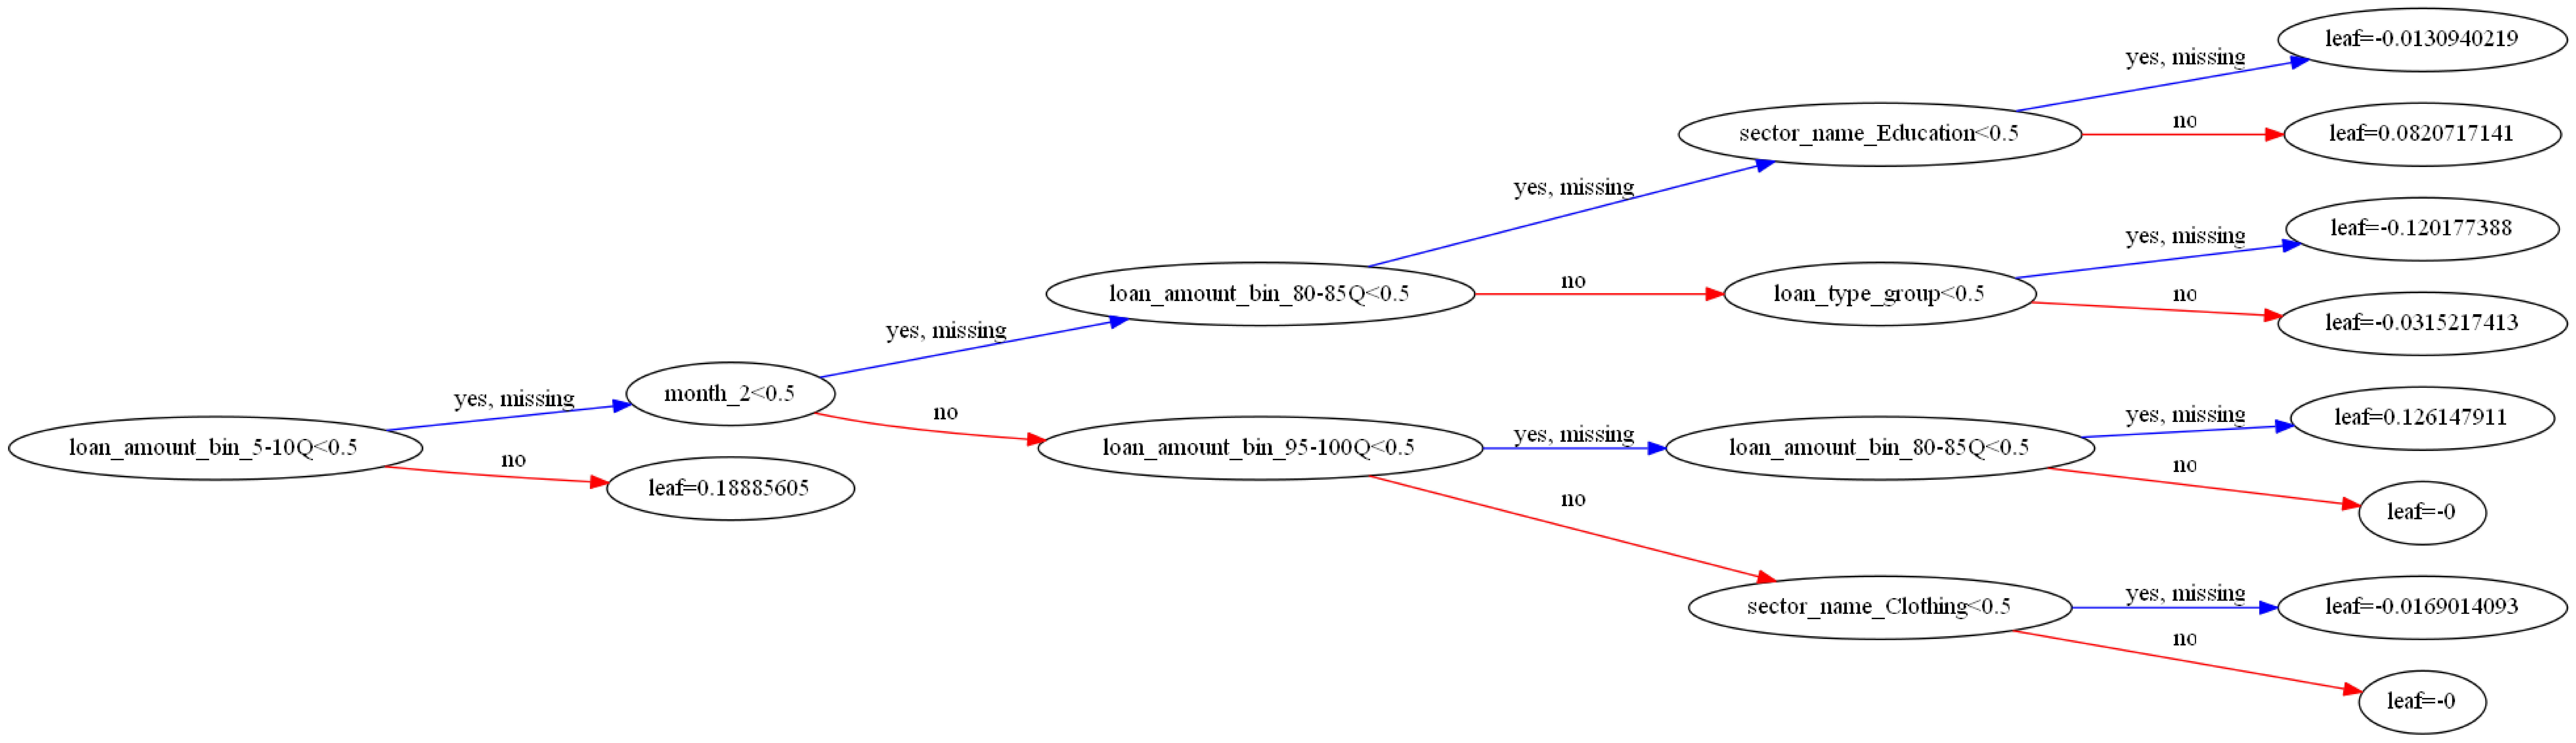

In [41]:
# Visualize the XGBoost decision tree
from matplotlib.pylab import rcParams

xgb.plot_tree(xg_orig,num_trees=0, rankdir='LR')
#plt.rcParams['figure.figsize'] = [100, 100]
#plt.show()
fig = plt.gcf()
fig.set_size_inches(200, 200)
#fig.savefig('orig_tree.png')

In [42]:
# Visualize the XGBoost decision tree
from matplotlib.pylab import rcParams

xgb.plot_tree(xg_orig,num_trees=9, rankdir='LR')
#plt.rcParams['figure.figsize'] = [100, 100]
#plt.show()
fig = plt.gcf()
fig.set_size_inches(200, 200)
#fig.savefig('orig_tree.png')



In [43]:
#xgb.to_graphviz(xg_orig, num_trees=9, rankdir='UT', yes_color=None, no_color=None, 
#                      condition_node_params={'fontsize': '100'}, leaf_node_params={'fontsize': '100'})
cNodeParams = {'shape':'box',
               'style':'filled,rounded',
               'fillcolor':'#78bceb',
               'fontsize':'22'
              }
lNodeParams = {'shape':'box',
               'style':'filled',
               'fillcolor':'#e48038',
               'fontsize':'22'
              }
gvz = xgb.to_graphviz(xg_orig, num_trees=9, rankdir='LR', yes_color=None, no_color=None, 
                      condition_node_params=cNodeParams, leaf_node_params=lNodeParams,**{'size':str(10)})
print(gvz.source)

digraph {
    graph [ rankdir=TB ]
    graph [ rankdir="LR" ]
    graph [ size="10" ]

    0 [ label="gender_reclassified_female<0.5" fillcolor="#78bceb" fontsize="22" shape="box" style="filled,rounded" ]
    0 -> 1 [label="yes, missing" color="#0000FF"]
    0 -> 2 [label="no" color="#FF0000"]

    1 [ label="world_region_East Asia and the Pacific<0.5" fillcolor="#78bceb" fontsize="22" shape="box" style="filled,rounded" ]
    1 -> 3 [label="yes, missing" color="#0000FF"]
    1 -> 4 [label="no" color="#FF0000"]

    3 [ label="loan_amount_bin_20-25Q<0.5" fillcolor="#78bceb" fontsize="22" shape="box" style="filled,rounded" ]
    3 -> 7 [label="yes, missing" color="#0000FF"]
    3 -> 8 [label="no" color="#FF0000"]

    7 [ label="sector_name_Construction<0.5" fillcolor="#78bceb" fontsize="22" shape="box" style="filled,rounded" ]
    7 -> 15 [label="yes, missing" color="#0000FF"]
    7 -> 16 [label="no" color="#FF0000"]

    15 [ label="leaf=-0.0708613098" fillcolor="#e48038" fontsize="22"

In [44]:
#!pip install pydot

**Feature importance (niet gebruiken in thesis want SHAP plots geven zelfde info)**

Examine the importance of each feature column in the original dataset within the model:
 * Method = 'gain': the relative contribution of the corresponding feature to the model calculated by taking each feature’s contribution for each tree in the model. ‘Gain’ is the improvement in accuracy brought by a feature to the branches it is on.

Why 'gain' method is most appropriate:
* Most likely, the variable gender has much smaller number of possible values (often only two: male/female) compared to other predictors in your data. So this binary feature can be used at most once in each tree, while, let say, sector (with a higher number of possible values) might appear much more often on different levels of the trees. Therefore, such binary feature will get a very low importance based on the frequency/weight metric, but a very high importance based on both the gain, and coverage metrics!

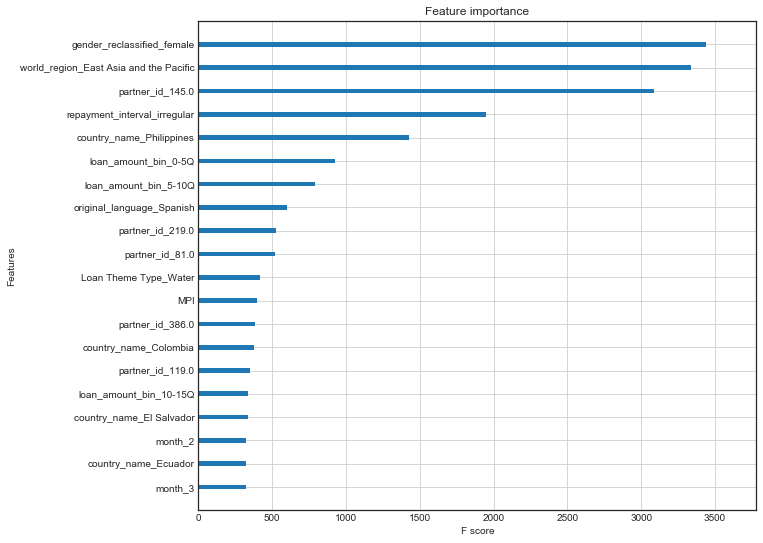

In [33]:
xgb.plot_importance(xg_orig, max_num_features=20, importance_type='gain', show_values=False)
plt.rcParams['figure.figsize'] = [10, 9]
#plt.savefig('Origin_feature.png', bbox_inches="tight")

### SHAP baseline

In [38]:
# https://towardsdatascience.com/interpretable-machine-learning-with-xgboost-9ec80d148d27

explainer = shap.TreeExplainer(xg_orig)
shap_values = explainer.shap_values(X_test)

In [39]:
# Base value
probs.mean()

0.49999994

Het berekenen van de SHAP values vertrekt van de mean prediction (voor het baseline model is dit 0.39). Vervolgens vergelijken we de prediction van een bepaalde lening (vb. kans op funded van 0.90) met de mean prediction. Dit verschil bedraagt 0.51. De SHAP values geven vervolgens weer wat de bijdrage/contributie is van een bepaalde feature value (vb. repayment interval = irregular) tot het verschil van 0.51. 

Op deze manier geven zeer positieve SHAP values aan dat de feature value veel bijdraagt tot het voorspellen als funded. Terwijl zeer negatieve SHAP values bijdragen tot het voorspellen als expired.

Onderstaande grafieken plotten de SHAP values voor elke one hot encoded feature afzonderlijk. Dit kan een wat vertekend beeld geven als we vb het belang van de volledige feature 'loan amount' willen weten.

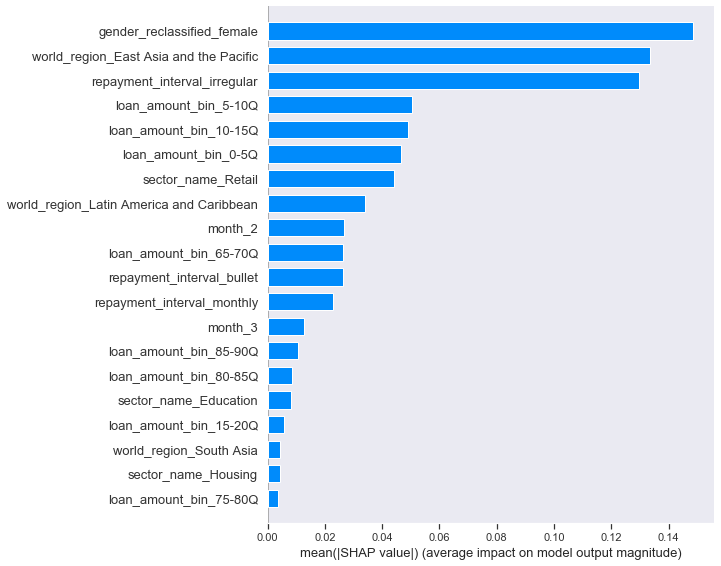

In [101]:
shap.summary_plot(shap_values, X_test, plot_type="bar")

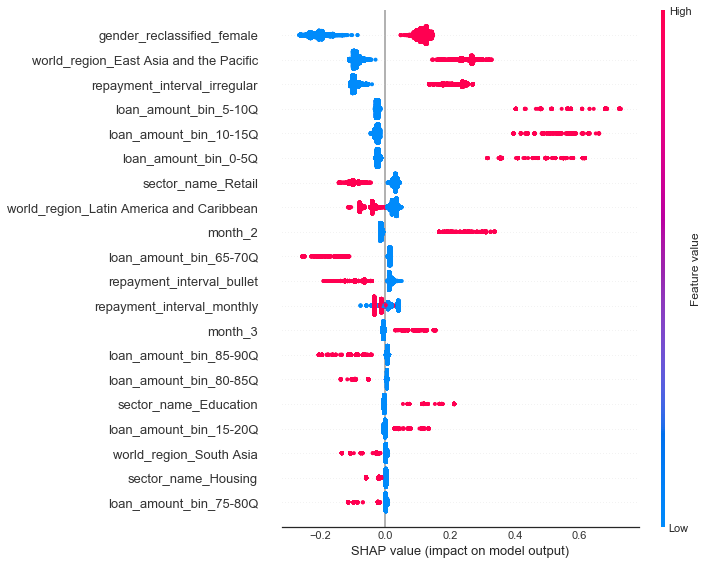

In [41]:
import matplotlib.pyplot as plt
f = plt.figure()
shap.summary_plot(shap_values, X_test)
f.savefig("summary_plot_orig.png", bbox_inches='tight', dpi=600)

In onderstaande code eerst wat pre-processen om de SHAP values van de one-hot encoded features op te tellen voor elke instance. Zo bekomen we voor elke instance een SHAP value per feature. De SHAP value van een feature (vb. loan amount) geeft dan de bijdrage tot de prediction van een bepaalde lening.

In [40]:
shap_values2 = shap_values.copy()

# group all dummies of a category together
gender_reclassified_female = shap_values2[:,0:1]
sector_df = shap_values2[:,1:15+1]
loan_type_df = shap_values2[:,16:17+1]
world_region_df = shap_values2[:,18:23+1]
repayment_interval_df = shap_values2[:,24:26+1]
month_df = shap_values2[:,27:38+1]
loan_amount_df = shap_values2[:,39:58+1]

# sum SHAP values of each category
gender_female = gender_reclassified_female.sum(axis=1) #Enkel om array flat te maken
sector = sector_df.sum(axis=1)
loan_type = loan_type_df.sum(axis=1)
world_region = world_region_df.sum(axis=1)
repayment_interval = repayment_interval_df.sum(axis=1)
month = month_df.sum(axis=1)
loan_amount = loan_amount_df.sum(axis=1)

# Merge all categories
merge_shap = np.stack([gender_female, sector,
                            loan_type, world_region, repayment_interval,
                            month, loan_amount], axis=-1)
# Check
len(merge_shap)

20982

In [41]:
X_test2 = X_test.copy()

# group all dummies of a category together
gender_reclassified_female = X_test2.iloc[:,0:1]
sector_df2 = X_test2.iloc[:,1:15+1]
loan_type_df2 = X_test2.iloc[:,16:17+1]
world_region_df2 = X_test2.iloc[:,18:23+1]
repayment_interval_df2 = X_test2.iloc[:,24:26+1]
month_df2 = X_test2.iloc[:,27:38+1]
loan_amount_df2 = X_test2.iloc[:,39:58+1]

# Define function to remove prefix for each category
def remove_prefix(prefix):
    return lambda x: x[len(prefix):]

# Remove prefixes and group dummies for each category
sector1 = sector_df2.rename(remove_prefix('sector_name_'), axis='columns')
sector2 = pd.get_dummies(sector1).idxmax(1)
sector = pd.DataFrame(sector2,columns=['sector'])

loan_type1 = loan_type_df2.rename(remove_prefix('loan_type_'), axis='columns')
loan_type2 = pd.get_dummies(loan_type1).idxmax(1)
loan_type = pd.DataFrame(loan_type2,columns=['loan_type'])

world_region1 = world_region_df2.rename(remove_prefix('world_region_'), axis='columns')
world_region2 = pd.get_dummies(world_region1).idxmax(1)
world_region = pd.DataFrame(world_region2,columns=['world_region'])

repayment_interval1 = repayment_interval_df2.rename(remove_prefix('repayment_interval_'), axis='columns')
repayment_interval2 = pd.get_dummies(repayment_interval1).idxmax(1)
repayment_interval = pd.DataFrame(repayment_interval2,columns=['repayment_interval'])

month1 = month_df2.rename(remove_prefix('month_'), axis='columns')
month2 = pd.get_dummies(month1).idxmax(1)
month = pd.DataFrame(month2,columns=['month'])

loan_amount1 = loan_amount_df2.rename(remove_prefix('loan_amount_'), axis='columns')
loan_amount2 = pd.get_dummies(loan_amount1).idxmax(1)
loan_amount = pd.DataFrame(loan_amount2,columns=['loan_amount'])

# Merge all categories
merge_X_test = pd.concat([gender_reclassified_female, sector,
                            loan_type, world_region, repayment_interval,
                            month, loan_amount], axis=1, sort=False)
# Check
len(merge_X_test)


20982

In [42]:
# Check
merge_X_test.head()

gender_reclassified_female       sector   loan_type  \
9159                          1.0  Agriculture  individual   
43565                         0.0  Agriculture  individual   
24819                         1.0     Services  individual   
67453                         0.0  Agriculture  individual   
30751                         1.0       Retail  individual   

                      world_region repayment_interval month loan_amount  
9159     East Asia and the Pacific          irregular     4  bin_15-20Q  
43565  Latin America and Caribbean             bullet     8  bin_85-90Q  
24819    East Asia and the Pacific          irregular     7  bin_15-20Q  
67453  Latin America and Caribbean            monthly    10  bin_45-50Q  
30751  Latin America and Caribbean          irregular     3  bin_60-65Q

In [43]:
# Check
X_test.head()

gender_reclassified_female  sector_name_Agriculture  sector_name_Arts  \
9159                          1.0                      1.0               0.0   
43565                         0.0                      1.0               0.0   
24819                         1.0                      0.0               0.0   
67453                         0.0                      1.0               0.0   
30751                         1.0                      0.0               0.0   

       sector_name_Clothing  sector_name_Construction  sector_name_Education  \
9159                    0.0                       0.0                    0.0   
43565                   0.0                       0.0                    0.0   
24819                   0.0                       0.0                    0.0   
67453                   0.0                       0.0                    0.0   
30751                   0.0                       0.0                    0.0   

       sector_name_Entertainment  sector_name_Food  sector_name_Health  \
9159                         0.0               0.0                 0.0   
43565                        0.0               0.0                 0.0   
24819                        0.0               0.0                 0.0   
67453                        0.0               0.0                 0.0   
30751                        0.0               0.0                 0.0   

       sector_name_Housing  ...  loan_amount_bin_50-55Q  \
9159                   0.0  ...                     0.0   
43565                  0.0  ...                     0.0   
24819                  0.0  ...                     0.0   
67453                  0.0  ...                     0.0   
30751                  0.0  ...                     0.0   

       loan_amount_bin_55-60Q  loan_amount_bin_60-65Q  loan_amount_bin_65-70Q  \
9159                      0.0                     0.0                     0.0   
43565                     0.0                     0.0                     0.0   
24819                     0.0                     0.0                     0.0   
67453                     0.0                     0.0                     0.0   
30751                     0.0                     1.0                     0.0   

       loan_amount_bin_70-75Q  loan_amount_bin_75-80Q  loan_amount_bin_80-85Q  \
9159                      0.0                     0.0                     0.0   
43565                     0.0                     0.0                     0.0   
24819                     0.0                     0.0                     0.0   
67453                     0.0                     0.0                     0.0   
30751                     0.0                     0.0                     0.0   

       loan_amount_bin_85-90Q  loan_amount_bin_90-95Q  loan_amount_bin_95-100Q  
9159                      0.0                     0.0                      0.0  
43565                     1.0                     0.0                      0.0  
24819                     0.0                     0.0                      0.0  
67453                     0.0                     0.0                      0.0  
30751                     0.0                     0.0                      0.0  

[5 rows x 59 columns]

In [44]:
merge_X_test_encoded = merge_X_test.copy()

categorical_names = {}
encoders = {}

# Use Label Encoder for categorical columns (including target column)
for feature in merge_X_test_encoded.columns:
    if feature != 'gender_reclassified_female' and feature !='month':
        le = LabelEncoder()
        le.fit(merge_X_test_encoded[feature])

        merge_X_test_encoded[feature] = le.transform(merge_X_test_encoded[feature])
    
    #categorical_names[feature] = le.classes_
    #encoders[feature] = le

In [45]:
merge_X_test_encoded.head()

gender_reclassified_female  sector  loan_type  world_region  \
9159                          1.0       0          1             1   
43565                         0.0       0          1             3   
24819                         1.0      12          1             1   
67453                         0.0       0          1             3   
30751                         1.0      11          1             3   

       repayment_interval month  loan_amount  
9159                    1     4            2  
43565                   0     8           17  
24819                   1     7            2  
67453                   2    10            8  
30751                   1     3           12

First, visualize a couple of single predictions:

In [46]:
merge_X_test.iloc[4,:]

gender_reclassified_female                              1
sector                                             Retail
loan_type                                      individual
world_region                  Latin America and Caribbean
repayment_interval                              irregular
month                                                   3
loan_amount                                    bin_60-65Q
Name: 30751, dtype: object

In [178]:
y_test.iloc[4]

1.0

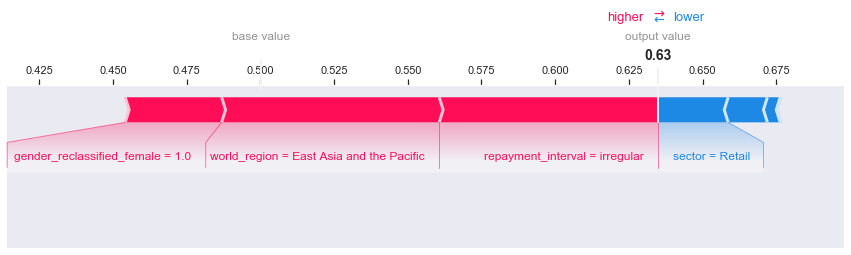

In [197]:
shap.force_plot(explainer.expected_value, merge_shap[8,:], merge_X_test.iloc[8,:], link="logit",show=False, matplotlib=True, figsize=(15,3))
f = plt.gcf()
f.savefig("force_plot_example.png", bbox_inches='tight')

In [169]:
merge_X_test.iloc[1,:]

gender_reclassified_female                              0
sector                                        Agriculture
loan_type                                      individual
world_region                  Latin America and Caribbean
repayment_interval                                 bullet
month                                                   8
loan_amount                                    bin_85-90Q
Name: 43565, dtype: object

In [174]:
y_test.iloc[1]

0.0

In [167]:
shap.force_plot(explainer.expected_value, merge_shap[1,:], merge_X_test.iloc[1,:], link="logit")

Onderstaande plot toont de importance van elke feature in zijn totaliteit. Wanneer we dit vergelijken met de summary plot waarin de features als one-hot encoded werden voorgesteld, zien we dat de volgorde verandert. Deze plot geeft dan ook een correcter beeld van de feature importance. 

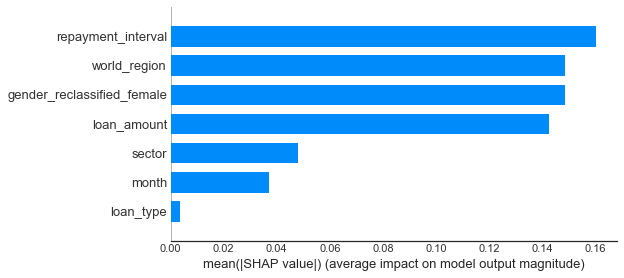

In [47]:
f = plt.figure()
shap.summary_plot(merge_shap, merge_X_test, plot_type="bar")
f.savefig("orig_global.png", bbox_inches='tight')

Vervolgens kunnen we voor de meest belangrijke features de SHAP values plotten voor elke feature value.

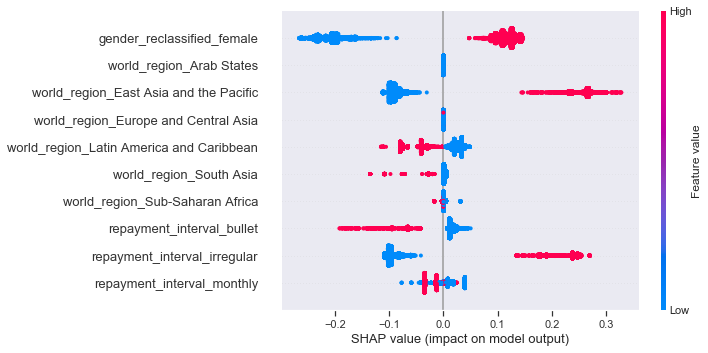

In [113]:
import matplotlib.pyplot as plt
f = plt.figure()
shap.summary_plot(shap_values[:, np.r_[0:1, 18:23+1, 24:26+1]], X_test.iloc[:, np.r_[0:1, 18:23+1, 24:26+1]], sort=False)
f.savefig("orig_summary_part1.png", bbox_inches='tight')

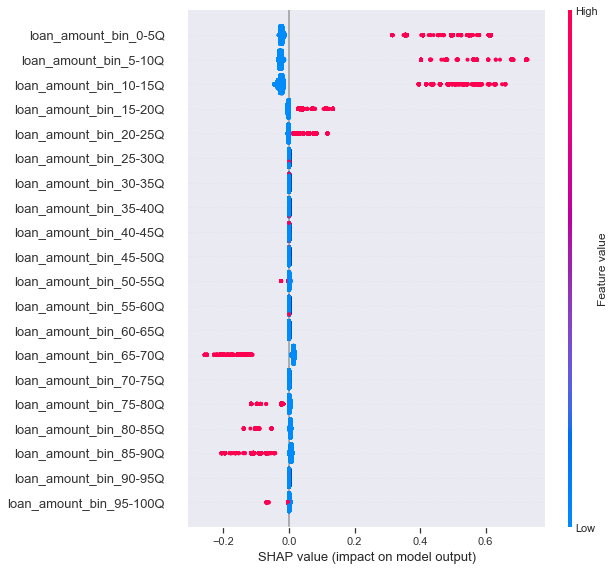

In [114]:
import matplotlib.pyplot as plt
f = plt.figure()
shap.summary_plot(shap_values[:,39:58+1], X_test.iloc[:,39:58+1], sort=False)
f.savefig("orig_summary_part2.png", bbox_inches='tight')

Deze plot is moeilijk te interpreteren (niet gebruiken).

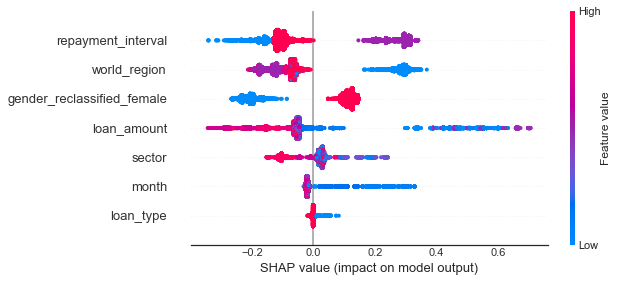

In [52]:
import matplotlib.pyplot as plt
f = plt.figure()
shap.summary_plot(merge_shap, merge_X_test_encoded)
f.savefig("summary_plot_orig_merge_shap.png", bbox_inches='tight', dpi=600)

Onderstaande plots zijn de dependency plots tussen telkens twee features. Twee belangrijke inzichten uit deze plots zijn:
   * Gender X sector: Het baseline model geeft een iets hogere kans om volledig gefund te worden aan vrouwen over bijna alle sectoren uitgezonderd de sector Education.
   * Gender X loan amount: Het model vertoont geen grote verschillen op basis van geslacht bij het voorspellen van zowel een kleine als een grote lening.

Parameter alpha: The transparency of the data points (between 0 and 1). 
This can be useful to show the density of the data points when using a large dataset.

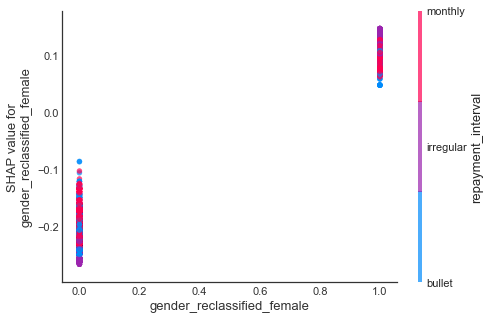

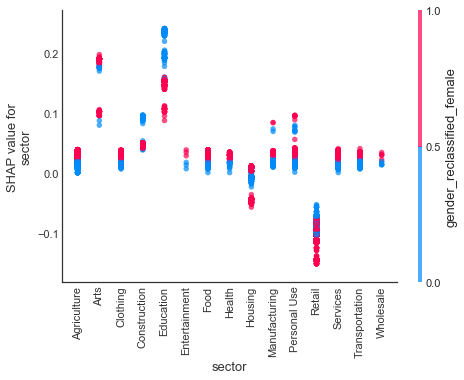

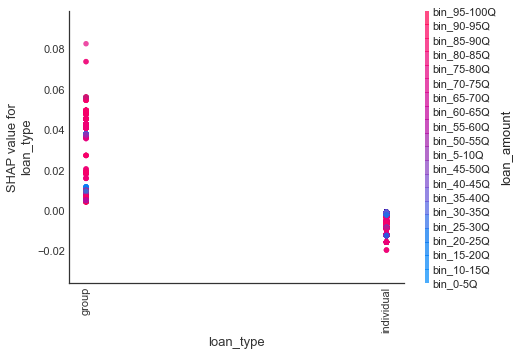

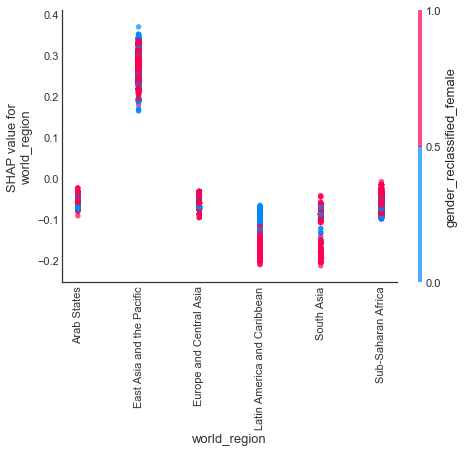

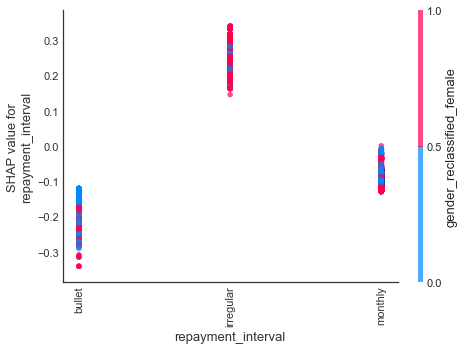

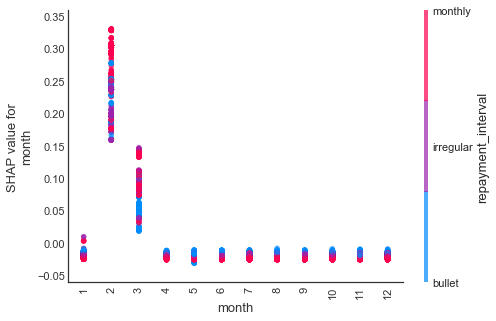

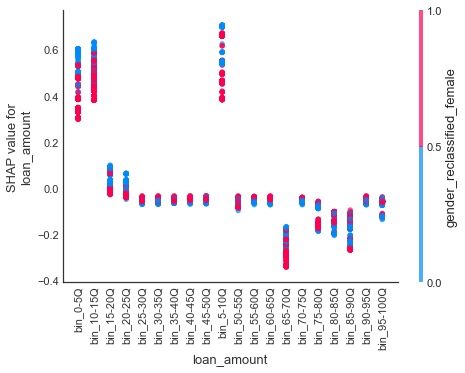

In [53]:
for name in merge_X_test.columns:
    shap.dependence_plot(name, merge_shap, merge_X_test_encoded, display_features=merge_X_test, dot_size=30, alpha=0.7)

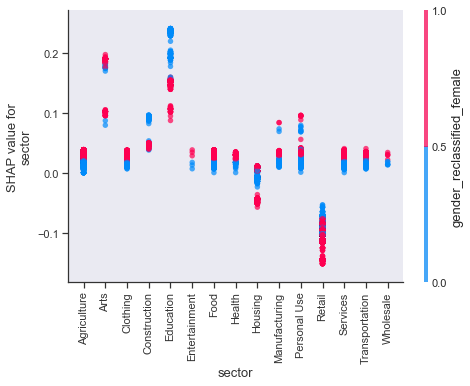

In [122]:
import matplotlib.pyplot as plt
shap.dependence_plot('sector', merge_shap, merge_X_test_encoded, interaction_index="gender_reclassified_female",
                     display_features=merge_X_test, dot_size=30, alpha=0.7,show=False)
f = plt.gcf()
f.savefig("orig_dependency_sector_gender.png", bbox_inches='tight')

**Grafieken ter controle (dus niet belangrijk)**

In [44]:
# https://towardsdatascience.com/interpretable-machine-learning-with-xgboost-9ec80d148d27
# this takes a minute or two since we are explaining over 30 thousand samples in a model with over a thousand trees
explainer = shap.TreeExplainer(xg_orig)
shap_values = explainer.shap_values(X_test[:5])

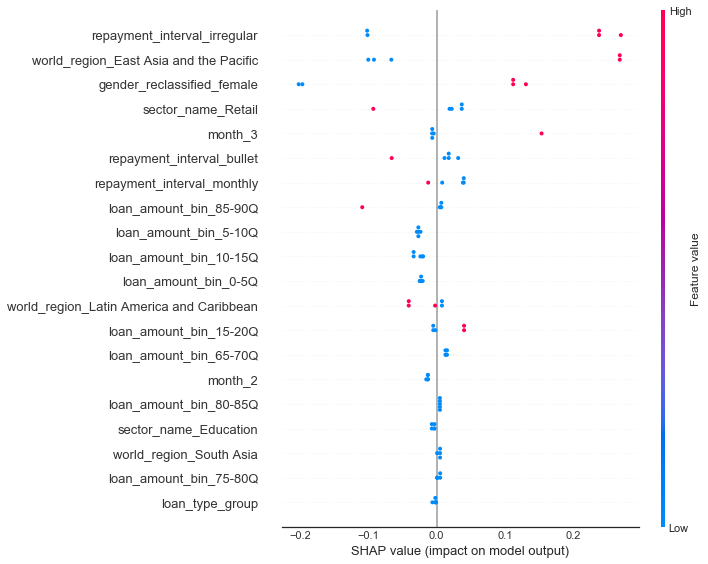

In [45]:
shap.summary_plot(shap_values, X_test[:5])

In [166]:
summary_df = pd.DataFrame([X_test.columns, 
                           abs(shap_values).mean(axis=0)]).T
summary_df.columns = ['Feature', 'mean_SHAP']

In [167]:
# https://towardsdatascience.com/opening-black-boxes-how-to-leverage-explainable-machine-learning-dd4ab439998e
summary_df = pd.DataFrame([X_test.columns, 
                           abs(shap_values).mean(axis=0)]).T
summary_df.columns = ['Feature', 'mean_SHAP']

mapping = {}

for feature in summary_df.Feature.values:
    mapping[feature] = feature
    for prefix, alternative in zip(['loan_amount_bin', 'world_region',  
                                    'repayment_interval', 'month',  
                                    'sector_name', 'loan_type'],
                                   ['Loan amount', 'World region', 
                                    'Repayment interval', 'Posted month', 
                                    'Sector', 'Loan type']):
        if feature.startswith(prefix):
            mapping[feature] = alternative
            break
            
summary_df['Feature'] = summary_df.Feature.map(mapping)
shap_df = (summary_df.groupby('Feature')
                    .sum()
                    .sort_values("mean_SHAP", ascending=False)
                    .reset_index())

In [169]:
shap_df

Feature  mean_SHAP
0                 Loan amount   0.204751
1          Repayment interval   0.178918
2                World region   0.172645
3  gender_reclassified_female   0.148453
4                      Sector   0.060134
5                Posted month   0.039743
6                   Loan type   0.003472

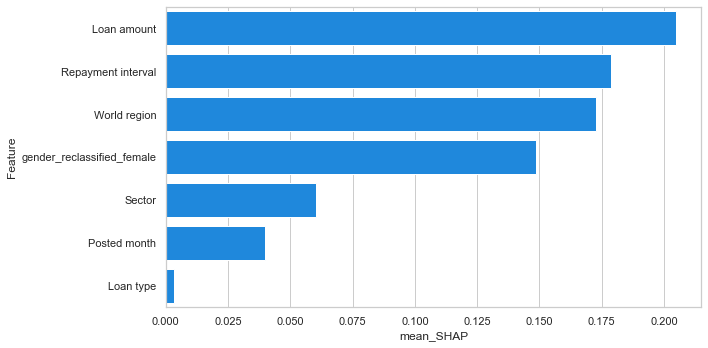

In [170]:
import seaborn as sns
import matplotlib.pyplot as plt
sns.set(style="whitegrid")

# Initialize the matplotlib figure
f, ax = plt.subplots(figsize=(10, 5))

sns.barplot(x="mean_SHAP", y="Feature", data=shap_df[:10],
            label="Total", color="#008BFB")
plt.tight_layout()
#plt.savefig('summary_shap.png', dpi=300)

## Bias detection with AIF360

After constructing the baseline model, we quantify the gender bias in the baseline model by using the AIF360 fairness metrics. Afterwards, this bias is mitigated by implementing two pre-processing algorithms (LFR & Reweighing) and two post-processing algorithms (Reject option based classification & Equality of odds).

Source code: https://www.kaggle.com/nathanlauga/ethics-and-ai-how-to-prevent-bias-on-ml

So with aif360 we have some metrics that indicate if our data or model contains some bias. 
* Statistical Parity Difference


$$ Pr(Y=1|D=unprivileged) - Pr(Y=1|D=privileged) $$



    So it has to be close to **0** so it will be fair.
* Equal Opportunity Difference


$$ TPR_{D=unprivileged} - TPR_{D=privileged} $$ 



    Same as the previous metric we need it to be close to **0**.
* Average Absolute Odds Difference


$$ \frac{1}{2}[|FPR_{D=unprivileged} - FPR_{D=privileged} | + | TPR_{D=unprivileged} - TPR_{D=privileged}|]$$

    It needs to be equal to **0** to be fair.
* Disparate Impact


$$ \frac{Pr(Y=1|D=unprivileged)}{Pr(Y=1|D=privileged)} $$


    It changes the objective, for the disparate impact it's **1** that we need.
* Theil Index


$$ \frac{1}{n} \sum_{i=0}^{n} \frac{b_i}{\mu} ln \frac{b_i}{\mu} $$ 
        Where $b_i = \hat{y}_i - y_i + 1 $
    
    It needs to be close to **0** to be fair.


In [29]:
# This DataFrame is created to stock differents models and fair metrics that we produce in this notebook
algo_metrics = pd.DataFrame(columns=['model', 'fair_metrics', 'prediction', 'probs'])

def add_to_df_algo_metrics(algo_metrics, model, fair_metrics, preds, probs, name):
    return algo_metrics.append(pd.DataFrame(data=[[model, fair_metrics, preds, probs]], columns=['model', 'fair_metrics', 'prediction', 'probs'], index=[name]))

In [30]:
def fair_metrics(data_transf_test, pred, pred_is_dataset=False):
    if pred_is_dataset:
        dataset_pred = pred
    else:
        dataset_pred = data_transf_test.copy()
        dataset_pred.labels = pred
    
    cols = ['statistical_parity_difference', 'equal_opportunity_difference', 'average_abs_odds_difference',  'disparate_impact', 'theil_index', 'consistency']
    obj_fairness = [[0,0,0,1,0,1]]
    
    fair_metrics = pd.DataFrame(data=obj_fairness, index=['objective'], columns=cols)
    
    for attr in dataset_pred.protected_attribute_names:
        idx = dataset_pred.protected_attribute_names.index(attr)
        privileged_groups =  [{attr:dataset_pred.privileged_protected_attributes[idx][0]}] 
        unprivileged_groups = [{attr:dataset_pred.unprivileged_protected_attributes[idx][0]}] 
        
        classified_metric = ClassificationMetric(data_transf_test, 
                                                     dataset_pred,
                                                     unprivileged_groups=unprivileged_groups,
                                                     privileged_groups=privileged_groups)

        metric_pred = BinaryLabelDatasetMetric(dataset_pred,
                                                     unprivileged_groups=unprivileged_groups,
                                                     privileged_groups=privileged_groups)

        acc = classified_metric.accuracy()

        row = pd.DataFrame([[metric_pred.mean_difference(), 
                                classified_metric.equal_opportunity_difference(),
                                classified_metric.average_abs_odds_difference(),
                                metric_pred.disparate_impact(), 
                                classified_metric.theil_index(),
                                float(metric_pred.consistency(n_neighbors=10))]],
                           columns  = cols,
                           index = [attr]
                          )
        fair_metrics = fair_metrics.append(row)    
    
    fair_metrics = fair_metrics.replace([-np.inf, np.inf], 2)
        
    return fair_metrics

def plot_fair_metrics(fair_metrics):
    fig, ax = plt.subplots(figsize=(20,4), ncols=6, nrows=1)

    plt.subplots_adjust(
        left    =  0.125, 
        bottom  =  0.1, 
        right   =  0.9, 
        top     =  0.9, 
        wspace  =  .5, 
        hspace  =  1.1
    )

    y_title_margin = 1.2

    plt.suptitle("Fairness metrics", y = 1.09, fontsize=20)
    sns.set(style="dark")

    cols = fair_metrics.columns.values
    obj = fair_metrics.loc['objective']
    size_rect = [0.2,0.2,0.2,0.4,0.25,0.2]
    rect = [-0.1,-0.1,-0.1,0.8,0,0.9]
    bottom = [-1,-1,-1,0,0,0]
    top = [1,1,1,2,1,2]
    bound = [[-0.1,0.1],[-0.1,0.1],[-0.1,0.1],[0.8,1.2],[0,0.25],[0.9,1.1]]

    display(Markdown("### Check bias metrics :"))
    display(Markdown("A model can be considered bias if just one of these six metrics show that this model is biased."))
    for attr in fair_metrics.index[1:len(fair_metrics)].values:
        display(Markdown("#### For the %s attribute :"%attr))
        check = [bound[i][0] < fair_metrics.loc[attr][i] < bound[i][1] for i in range(0,6)]
        display(Markdown("With default thresholds, bias against unprivileged group detected in **%d** out of 6 metrics"%(6 - sum(check))))

    for i in range(0,6):
        plt.subplot(1, 6, i+1)
        ax = sns.barplot(x=fair_metrics.index[1:len(fair_metrics)], y=fair_metrics.iloc[1:len(fair_metrics)][cols[i]])
        
        for j in range(0,len(fair_metrics)-1):
            a, val = ax.patches[j], fair_metrics.iloc[j+1][cols[i]]
            marg = -0.2 if val < 0 else 0.1
            ax.text(a.get_x()+a.get_width()/6, a.get_y()+a.get_height()+marg, round(val, 3), fontsize=15,color='black')

        plt.ylim(bottom[i], top[i])
        plt.setp(ax.patches, linewidth=0)
        ax.add_patch(patches.Rectangle((-6,rect[i]), 10, size_rect[i], alpha=0.3, facecolor="green", linewidth=1, linestyle='solid'))
        plt.axhline(obj[i], color='black', alpha=0.3)
        plt.title(cols[i])
        ax.set_ylabel('')    
        ax.set_xlabel('')

In [31]:
def get_fair_metrics_and_plot(data_transf_test, model, plot=True, model_aif=False):
    pred = model.predict(data_transf_test).labels if model_aif else model.predict(data_transf_test.features) 
    # fair_metrics function available in the metrics.py file
    fair = fair_metrics(data_transf_test, pred)

    if plot:
        # plot_fair_metrics function available in the visualisations.py file
        # The visualisation of this function is inspired by the dashboard on the demo of IBM aif360 
        plot_fair_metrics(fair)
        display(fair)
    
    return fair

### Bias metrics for the model

### Check bias metrics :

A model can be considered bias if just one of these six metrics show that this model is biased.

#### For the gender_reclassified_female attribute :

With default thresholds, bias against unprivileged group detected in **4** out of 6 metrics

statistical_parity_difference  \
objective                                        0.000000   
gender_reclassified_female                      -0.443126   

                            equal_opportunity_difference  \
objective                                       0.000000   
gender_reclassified_female                     -0.397743   

                            average_abs_odds_difference  disparate_impact  \
objective                                      0.000000          1.000000   
gender_reclassified_female                     0.322125          0.192419   

                            theil_index  consistency  
objective                      0.000000     1.000000  
gender_reclassified_female     0.225957     0.936141

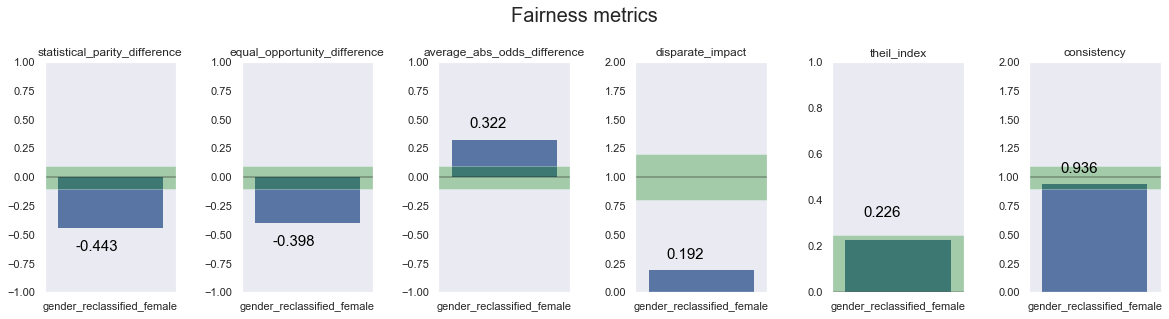

In [32]:
display(Markdown('### Bias metrics for the model'))
fair = get_fair_metrics_and_plot(data_orig_sex_test, xg_orig_sex)

The AIF360 metrics show a clear gender bias which was also confirmed by our NLP model. However, the baseline model is still individually fair which means that borrowers with similar features get similar outcomes.

In [33]:
data_orig_test = data_orig_sex_test
data_orig_train = data_orig_sex_train
xg = xg_orig_sex

probs = xg.predict_proba(data_orig_test.features)
preds = xg.predict(data_orig_test.features)
algo_metrics = add_to_df_algo_metrics(algo_metrics, xg, fair, preds, probs, 'Origin')

## Bias mitigation with AIF360 algorithms

### Pre-processing

In [34]:
def get_attributes(data, selected_attr=None):
    unprivileged_groups = []
    privileged_groups = []
    if selected_attr == None:
        selected_attr = data.protected_attribute_names
    
    for attr in selected_attr:
            idx = data.protected_attribute_names.index(attr)
            privileged_groups.append({attr:data.privileged_protected_attributes[idx]}) 
            unprivileged_groups.append({attr:data.unprivileged_protected_attributes[idx]}) 

    return privileged_groups, unprivileged_groups

**Learning fair representations**

Source : [Zemel et al., 2013](http://proceedings.mlr.press/v28/zemel13.html)

Learning fair representations is a pre-processing technique that finds a latent representation which encodes the data well but obfuscates information about protected attributes.

Hyperparameters:
- Default: Ax=0.01 / Ay=1 / Az=50 / K=5 => metrics -0.6857 / 0 / 0 / 0.0602 / 0 with accuracy = 70%
- Ax=1 / Ay=0.21 / Az=1 / K=5 => metrics -0.0941 / 0 / 0 / 0.8253 / 0 with accuracy = 62.65%

In [35]:
#privileged_groups, unprivileged_groups = get_attributes(data_orig_train, selected_attr=['gender_reclassified'])
privileged_groups = [{'gender_reclassified_female': 1}]
unprivileged_groups = [{'gender_reclassified_female': 0}]
t0 = time()

LFR_model = LFR(unprivileged_groups=unprivileged_groups, privileged_groups=privileged_groups,
                Ax=1, Ay=0.21, Az=1, k=5, print_interval=250, verbose=1, seed=42)
# LFR.fit(data_orig_train)
data_transf_train = LFR_model.fit_transform(data_orig_train)

# Train and save the model
xg_reg = xgb.XGBClassifier(objective ='binary:logistic', colsample_bytree = 0.3, learning_rate = 0.1,
                max_depth = 4, alpha = 10, n_estimators = 10)
xg_transf = xg_reg.fit(data_transf_train.features, 
                     data_transf_train.labels.ravel(), 
                     sample_weight=data_transf_train.instance_weights)

data_transf_test = LFR_model.transform(data_orig_test)

fair = get_fair_metrics_and_plot(data_transf_test, xg_transf, plot=False)
probs = xg_transf.predict_proba(data_transf_test.features)
preds = xg_transf.predict(data_transf_test.features)

algo_metrics = add_to_df_algo_metrics(algo_metrics, xg_transf, fair, preds, probs, 'LFR')
print('time elapsed : %.2fs'%(time()-t0))

250 752921.208376276
500 570615.7296206412
750 570615.754445447
1000 318041.0162003738
1250 318041.0228838757
1500 297413.91531506856
1750 239676.3115352274
2000 239676.3730799927
2250 223988.81782073548
2500 223988.8158127358
2750 220479.84285186065
3000 216112.18780457304
3250 216112.185043147
3500 210026.91097075754
3750 210026.92126783123
4000 203513.53812224258
4250 191407.40218938288
4500 191407.40254474743
4750 189180.15988775
5000 189180.15531756595
time elapsed : 345.60s


In [36]:
fair

statistical_parity_difference  \
objective                                        0.000000   
gender_reclassified_female                      -0.094491   

                            equal_opportunity_difference  \
objective                                       0.000000   
gender_reclassified_female                      0.005087   

                            average_abs_odds_difference  disparate_impact  \
objective                                      0.000000          1.000000   
gender_reclassified_female                     0.002862          0.824885   

                            theil_index  consistency  
objective                      0.000000     1.000000  
gender_reclassified_female     0.002386     0.996035

In [37]:
accuracy_score(data_orig_test.labels.ravel(), preds)

0.6265370317414927

**Reweighing**

Source : [Kamiran and Calders, 2012](https://link.springer.com/article/10.1007%2Fs10115-011-0463-8)

Reweighing is a preprocessing technique that Weights the examples in each (group, label) combination differently to ensure fairness before classification.

In [38]:
#privileged_groups, unprivileged_groups = get_attributes(data_orig_train, selected_attr=['gender_reclassified'])
privileged_groups = [{'gender_reclassified_female': 1}]
unprivileged_groups = [{'gender_reclassified_female': 0}]
t0 = time()

RW = Reweighing(unprivileged_groups=unprivileged_groups, privileged_groups=privileged_groups)
RW.fit(data_orig_train)
data_transf_train = RW.fit_transform(data_orig_train)

# Train and save the model
xg_reg = xgb.XGBClassifier(objective ='binary:logistic', colsample_bytree = 0.3, learning_rate = 0.1,
                max_depth = 4, alpha = 10, n_estimators = 10)
xg_transf = xg_reg.fit(data_transf_train.features, 
                     data_transf_train.labels.ravel(), 
                     sample_weight=data_transf_train.instance_weights)

data_transf_test = RW.transform(data_orig_test)
fair = get_fair_metrics_and_plot(data_transf_test, xg_transf, plot=False)
probs = xg_transf.predict_proba(data_transf_test.features)
preds = xg_transf.predict(data_transf_test.features)

algo_metrics = add_to_df_algo_metrics(algo_metrics, xg_transf, fair, preds, probs, 'Reweighing')
print('time elapsed : %.2fs'%(time()-t0))

time elapsed : 52.87s


### In-processing

Fair in-processing algorithms have their own classifiers which are rather black-box models so these models are less appropriate.

### Post-processing

In [39]:
#from sklearn.linear_model import LogisticRegression

data_orig_test_pred = data_orig_test.copy(deepcopy=True)

# Prediction with the original XGBoost model
scores = np.zeros_like(data_orig_test.labels)

#lmod = LogisticRegression()
#lmod.fit(data_orig_train.features, data_orig_train.labels.ravel(), 
#                     sample_weight=data_orig_train.instance_weights)
#scores = lmod.predict_proba(data_orig_test.features)[:,1].reshape(-1,1)
#predictions = lmod.predict(data_orig_test.features).reshape(-1,1)

scores = xg.predict_proba(data_orig_test.features)[:,1].reshape(-1,1)
predictions = xg.predict(data_orig_test.features).reshape(-1,1)
data_orig_test_pred.scores = scores

#preds = np.zeros_like(data_orig_test.labels)
#preds = xg.predict(data_orig_test.features).reshape(-1,1)
#data_orig_test_pred.labels = preds

class_thresh = 0.5
preds = np.zeros_like(data_orig_test_pred.labels)
preds[scores >= class_thresh] = data_orig_test_pred.favorable_label
preds[~(scores >= class_thresh)] = data_orig_test_pred.unfavorable_label
data_orig_test_pred.labels = preds

def format_probs(probs1):
    probs1 = np.array(probs1)
    probs0 = np.array(1-probs1)
    return np.concatenate((probs0, probs1), axis=1)

**Equality of Odds**

Source : [Hardt et al., 2016](https://papers.nips.cc/paper/6374-equality-of-opportunity-in-supervised-learning)

Equalized odds postprocessing is a post-processing technique that solves a linear program to find probabilities with which to change output labels to optimize equalized odds. 

This linear program tries to find the tradeoff between ***false positive rate*** and ***true positive rate*** that optimizes the expected loss between the fair predictions and the true labels.

The concept of 'equalized odds' means that the predictions should have equal ***true positive rates*** across both genders for y = 1. For y = 0, it equalizes ***false positive rates***. The same reasoning applies for the ***true negative rates*** and the ***false negative rates***.

In [40]:
#privileged_groups, unprivileged_groups = get_attributes(data_orig_train, selected_attr=['gender_reclassified'])
privileged_groups = [{'gender_reclassified_female': 1}]
unprivileged_groups = [{'gender_reclassified_female': 0}]
t0 = time()

cost_constraint = "fpr" # "fnr", "fpr", "weighted"

EOPP = EqOddsPostprocessing(privileged_groups = privileged_groups,
                                     unprivileged_groups = unprivileged_groups,
                                     seed=42)

EOPP = EOPP.fit(data_orig_test, data_orig_test_pred)
data_transf_test_pred = EOPP.predict(data_orig_test_pred)
preds_EOPP = data_transf_test_pred.labels.ravel()

fair = fair_metrics(data_orig_test, data_transf_test_pred, pred_is_dataset=True) 

algo_metrics = add_to_df_algo_metrics(algo_metrics, 
                                      EOPP, 
                                      fair, 
                                      data_transf_test_pred.labels, 
                                      format_probs(data_transf_test_pred.scores), 
                                      'EqualityOdds')
print('time elapsed : %.2fs'%(time()-t0))

time elapsed : 52.89s


**Reject option classification**

Source : [Kamishima et al., 2012](https://ieeexplore.ieee.org/document/6413831/)

Reject option classification is a postprocessing technique that gives favorable outcomes to unpriviliged groups and unfavorable outcomes to priviliged groups in a confidence band around the decision boundary with the highest uncertainty.

In [41]:
#privileged_groups, unprivileged_groups = get_attributes(data_orig_train, selected_attr=['gender_reclassified'])
privileged_groups = [{'gender_reclassified_female': 1}]
unprivileged_groups = [{'gender_reclassified_female': 0}]
t0 = time()

ROC = RejectOptionClassification(privileged_groups = privileged_groups,
                             unprivileged_groups = unprivileged_groups)

ROC = ROC.fit(data_orig_test, data_orig_test_pred)
data_transf_test_pred = ROC.predict(data_orig_test_pred)

fair = fair_metrics(data_orig_test, data_transf_test_pred, pred_is_dataset=True)

algo_metrics = add_to_df_algo_metrics(algo_metrics, 
                                      ROC, 
                                      fair, 
                                      data_transf_test_pred.labels, 
                                      format_probs(data_transf_test_pred.scores), 
                                      'RejectOption')
print('time elapsed : %.2fs'%(time()-t0))

time elapsed : 149.04s


## Compare fairness metrics and accuracy

In [42]:
def plot_fair_metrics_plotly(fair_metrics):
    bottom = [-1, -1, -1, 0, 0, 0]
    max_valid = [0.1, 0.1, 0.1, 1.2, 0.25, 1.1]
    min_valid = [-0.1, -0.1, -0.1, 0.8, 0, 0.9]
    cols = fair_metrics.columns.values

    for i in range(0, 6):
        col = cols[i]

        x, y = (fair_metrics[col].values, fair_metrics.index)
        colors = []
        for v in x:
            color = '#e74c3c' if v < min_valid[i] or v > max_valid[i] else '#2ecc71'
            colors.append(color)

        trace = go.Bar(x=x, y=y, marker=dict(color=colors)
                       , opacity=0.9, orientation='h')

        layout = go.Layout(barmode='group',
                           title=col,
                           xaxis=dict(range=[bottom[i], bottom[i] + 2]),
                           yaxis=dict(automargin=True),
                           shapes=[
                               {
                                   'type': 'line',
                                   'x0': min_valid[i],
                                   'y0': -1,
                                   'x1': min_valid[i],
                                   'y1': len(y),
                                   'line': {
                                       'color': 'rgb(0, 0, 0)',
                                       'width': 2,
                                   },
                               }, {
                                   'type': 'line',
                                   'x0': max_valid[i],
                                   'y0': -1,
                                   'x1': max_valid[i],
                                   'y1': len(y),
                                   'line': {
                                       'color': 'rgb(0, 0, 0)',
                                       'width': 2,
                                   },
                               }])
        fig = go.Figure([trace], layout=layout)
        py.iplot(fig)


def plot_score_fair_metrics(score):
    display(score.sort_values(['nb_valid', 'score'], ascending=[0, 1]))
    score.sort_values(['nb_valid', 'score'], ascending=[1, 0], inplace=True)

    gold, silver, bronze, other = ('#FFA400', '#bdc3c7', '#cd7f32', '#3498db')
    colors = [gold if i == 0 else silver if i == 1 else bronze if i == 2 else other for i in range(0, len(score))]
    colors = [c for c in reversed(colors)]

    x, y = (score['score'].values, score.index)

    trace = go.Bar(x=x, y=y, marker=dict(color=colors)
                   , opacity=0.9, orientation='h')
    layout = go.Layout(barmode='group',
                       title='Fairest algorithm',
                       yaxis=dict(automargin=True))
    fig = go.Figure([trace], layout=layout)
    py.iplot(fig)
    

def score_fair_metrics(fair):
    objective = [0, 0, 0, 1, 0, 1]
    max_valid = [0.1, 0.1, 0.1, 1.2, 0.25, 1.1]
    min_valid = [-0.1, -0.1, -0.1, 0.8, -0.0001, 0.9]

    nb_valid = np.sum(((fair.values > min_valid) * (fair.values < max_valid)), axis=1)
    score = np.sum(np.abs(fair.values - objective), axis=1)
    score = np.array([score, nb_valid])

    score = pd.DataFrame(data=score.transpose(), columns=['score', 'nb_valid'], index=fair.index)
    return score


def score_all_attr(algo_metrics):
    attributes = algo_metrics.loc['Origin', 'fair_metrics'].index.values[1:]

    all_scores = np.zeros((len(algo_metrics), 2))
    for attr in attributes:
        df_metrics = pd.DataFrame(columns=algo_metrics.loc['Origin', 'fair_metrics'].columns.values)
        for fair in algo_metrics.loc[:, 'fair_metrics']:
            df_metrics = df_metrics.append(fair.loc[attr], ignore_index=True)
        all_scores = all_scores + score_fair_metrics(df_metrics).values

    final = pd.DataFrame(data=all_scores, columns=['score', 'nb_valid'], index=algo_metrics.index)
    return final
def compare_fair_metrics(algo_metrics, attr='gender_reclassified_female'):
    
    df_metrics = pd.DataFrame(columns=algo_metrics.loc['Origin','fair_metrics'].columns.values)
    for fair in algo_metrics.loc[:,'fair_metrics']:
        df_metrics = df_metrics.append(fair.loc[attr], ignore_index=True)

    df_metrics.index = algo_metrics.index.values
    df_metrics = df_metrics.replace([np.inf, -np.inf], np.NaN)
    
    display(df_metrics)
    plot_fair_metrics_plotly(df_metrics)
    score = score_fair_metrics(df_metrics)
    plot_score_fair_metrics(score.dropna())
    

In [43]:
compare_fair_metrics(algo_metrics)

statistical_parity_difference  equal_opportunity_difference  \
Origin                            -0.443126                     -0.397743   
LFR                               -0.094491                      0.005087   
Reweighing                        -0.118780                     -0.172811   
EqualityOdds                      -0.048392                      0.074094   
RejectOption                      -0.049199                      0.091672   

              average_abs_odds_difference  disparate_impact  theil_index  \
Origin                           0.322125          0.192419     0.225957   
LFR                              0.002862          0.824885     0.002386   
Reweighing                       0.121221          0.722077     0.229647   
EqualityOdds                     0.038724          0.787962     0.441661   
RejectOption                     0.093403          0.863393     0.292271   

              consistency  
Origin           0.936141  
LFR              0.996035  
Reweighing       0.925693  
EqualityOdds     0.777066  
RejectOption     0.919755

score  nb_valid
LFR           0.283906       6.0
RejectOption  0.743397       5.0
EqualityOdds  1.037843       3.0
Reweighing    0.994688       2.0
Origin        2.260391       2.0

In [75]:
def plot_compare_model_performance(algo_metrics, dataset):
    X_test = dataset.features
    y_true = dataset.labels
    perf_metrics = pd.DataFrame()

    models_name = algo_metrics.index.values

    fig = plt.figure(figsize=(7, 7))
    plt.title('ROC curve for differents models')
    lw = 2
    palette = sns.color_palette("Paired")

    for model_name, i in zip(models_name, range(0, len(models_name))):
        model = algo_metrics.loc[model_name, 'model']

        if model_name != 'AdvDebiasing':
            probs = algo_metrics.loc[model_name, 'probs']
            y_pred = algo_metrics.loc[model_name, 'prediction']
            accuracy, matrix, f1, fpr, tpr, roc_auc, recall, precision = get_model_performance(X_test, y_true, y_pred, probs)

            perf_metrics = perf_metrics.append(
                pd.DataFrame([[accuracy, recall, precision, f1]], columns=['Accuracy', 'Recall', 'Precision', 'F1 Score'], index=[model_name]))
            plt.plot(fpr, tpr, color=palette[i], lw=lw, label=str(model_name) + ' (area = %0.2f)' % roc_auc)

    plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic curve')
    plt.legend(loc="lower right")
    display(perf_metrics.sort_values(by=['Accuracy', 'Recall', 'Precision', 'F1 Score'], ascending=[False, False, False, False]))
    plt.show()

Accuracy    Recall  Precision  F1 Score
Baseline model  0.749357  0.638182   0.818584  0.717212
Reweighing      0.742732  0.634641   0.807599  0.710749
RejectOption    0.694452  0.536938   0.781150  0.636420
LFR             0.626537  0.632440   0.623255  0.627814
EqualityOdds    0.606853  0.316842   0.748926  0.445296

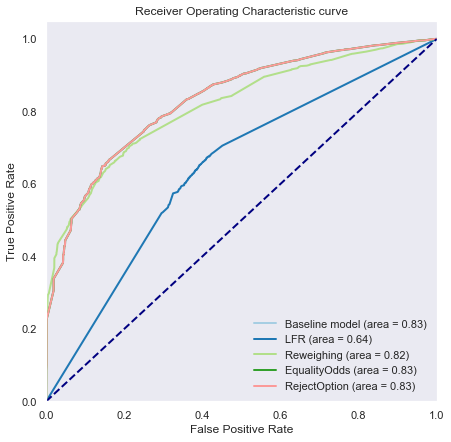

In [76]:
plot_compare_model_performance(algo_metrics, data_orig_test)

The AUC values for the post-processing algorithms are not meaningful because they are just the same as the baseline model.

In [72]:
def get_model_performance2(X_test, y_true, y_pred, probs):
    accuracy = accuracy_score(y_true, y_pred)
    matrix = confusion_matrix(y_true, y_pred)
    f1 = f1_score(y_true, y_pred)
    recall = recall_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred)
    preds = probs[:, 1]
    fpr, tpr, threshold = roc_curve(y_true, preds)
    roc_auc = auc(fpr, tpr)

    return accuracy, matrix, f1, fpr, tpr, roc_auc, recall, precision

def plot_compare_model_accuracy(algo_metrics, dataset):
    X_test = dataset.features
    y_true = dataset.labels
    perf_metrics = pd.DataFrame()
    #Rename 'Origin' to 'Baseline model'
    as_list = algo_metrics.index.tolist()
    if 'Origin' in as_list:
        idx = as_list.index('Origin')
        as_list[idx] = 'Baseline model'
        algo_metrics.index = as_list

    models_name = algo_metrics.index.values

    fig = plt.figure(figsize=(8, 4))
    #plt.title('Accuracy for differents models')
    lw = 2
    palette = sns.color_palette("Paired")

    acc = [] 
    recall2 = []
    precision2 = []
    f1_score = []
    models = []
    for model_name, i in zip(models_name, range(0, len(models_name))):
        model = algo_metrics.loc[model_name, 'model']
        probs = algo_metrics.loc[model_name, 'probs']
        y_pred = algo_metrics.loc[model_name, 'prediction']
        accuracy, matrix, f1, fpr, tpr, roc_auc, recall, precision = get_model_performance2(X_test, y_true, y_pred, probs)

        acc.append(accuracy)
        recall2.append(recall)
        precision2.append(precision)
        f1_score.append(f1)
        models.append(model_name)
    length = len(models)
    x = np.arange(length)
    ax = plt.subplot(111)
    width = 0.2 # width of bar
    ax.bar(x, acc, width=0.2, color='b', align='center', label='Accuracy')
    ax.bar(x + width, recall2, width=0.2, color='g', align='center', label='Recall')
    ax.bar(x + (2*width), precision2, width=0.2, color='r', align='center', label='Precision')
    ax.bar(x + (3*width), f1_score, width=0.2, color='y', align='center', label='F1 score')
    ax.set_xticks(x + width + width/2)
    ax.set_xticklabels(models)
    ax.legend(ncol=2)
    #plt.bar(models,performance, align='center', width=0.4)
    plt.ylim((0,1))
    plt.grid()
    plt.ylabel('Metric')
    plt.xlabel('Model')
    plt.savefig('metrics_models.png', bbox_inches="tight")
    

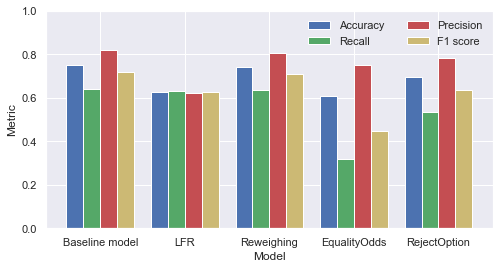

In [73]:
plot_compare_model_accuracy(algo_metrics, data_orig_test)

Better to compare the models based on accuracy, recall and precision. As such, the reweighing model shows the best accuracy and recall/precision compared to the baseline. A high recall is important because false negatives (i.e., wrongly classifying a funded loan as expired) are bad for the Kiva system.

## Check the best models

The Reweighing and RejectOption algorithms seem to make the best fairness-accuracy trade-off.

### Reweighing

In [123]:
#privileged_groups, unprivileged_groups = get_attributes(data_orig_train, selected_attr=['gender_reclassified'])
privileged_groups = [{'gender_reclassified_female': 1}]
unprivileged_groups = [{'gender_reclassified_female': 0}]
t0 = time()

RW = Reweighing(unprivileged_groups=unprivileged_groups, privileged_groups=privileged_groups)
RW.fit(data_orig_train)
data_transf_train = RW.fit_transform(data_orig_train)#### Reweighing


df2 = data_transf_train.convert_to_dataframe(de_dummy_code=False, sep='=', set_category=True)
df_train_transf = df2[0].copy()
df3 = data_orig_test.convert_to_dataframe(de_dummy_code=False, sep='=', set_category=True)
df_test_orig = df3[0].copy()

xg_orig = xgb.XGBClassifier(objective ='binary:logistic', colsample_bytree = 0.3, learning_rate = 0.1,
                max_depth = 4, alpha = 10, n_estimators = 10)

y_train= df_train_transf['status']
X_train= df_train_transf.drop('status',axis=1)
instance_weights = df2[1]['instance_weights'].copy()
xg_transf_RW = xg_orig.fit(X_train,y_train, sample_weight=instance_weights)

y_test= df_test_orig['status']
X_test= df_test_orig.drop('status',axis=1)
probs = xg_transf_RW.predict_proba(X_test)
preds = xg_transf_RW.predict(X_test)

from sklearn.metrics import accuracy_score
# evaluate predictions
accuracy = accuracy_score(y_test, preds)
print("Accuracy: %.2f%%" % (accuracy * 100.0))

Accuracy: 74.27%


In [74]:
instance_weights

array([1.32755898, 1.81294805, 0.8026245 , ..., 0.8026245 , 0.6896947 ,
       0.6896947 ])

**Decision tree**

In [68]:
# Plot decision tree
xgb.plot_tree(xg_transf_RW,num_trees=9, rankdir='LR')
#plt.rcParams['figure.figsize'] = [500, 100]
#plt.show()
fig = plt.gcf()
fig.set_size_inches(200, 200)
fig.savefig('RW_tree.png')

In [69]:
cNodeParams = {'shape':'box',
               'style':'filled,rounded',
               'fillcolor':'#78bceb',
               'fontsize':'22'
              }
lNodeParams = {'shape':'box',
               'style':'filled',
               'fillcolor':'#e48038',
               'fontsize':'22'
              }
gvz = xgb.to_graphviz(xg_transf_RW, num_trees=9, rankdir='LR', yes_color=None, no_color=None, 
                      condition_node_params=cNodeParams, leaf_node_params=lNodeParams,**{'size':str(10)})
print(gvz.source)

digraph {
    graph [ rankdir=TB ]
    graph [ rankdir="LR" ]
    graph [ size="10" ]

    0 [ label="world_region_East Asia and the Pacific<0.5" fillcolor="#78bceb" fontsize="22" shape="box" style="filled,rounded" ]
    0 -> 1 [label="yes, missing" color="#0000FF"]
    0 -> 2 [label="no" color="#FF0000"]

    1 [ label="sector_name_Retail<0.5" fillcolor="#78bceb" fontsize="22" shape="box" style="filled,rounded" ]
    1 -> 3 [label="yes, missing" color="#0000FF"]
    1 -> 4 [label="no" color="#FF0000"]

    3 [ label="sector_name_Housing<0.5" fillcolor="#78bceb" fontsize="22" shape="box" style="filled,rounded" ]
    3 -> 7 [label="yes, missing" color="#0000FF"]
    3 -> 8 [label="no" color="#FF0000"]

    7 [ label="loan_amount_bin_85-90Q<0.5" fillcolor="#78bceb" fontsize="22" shape="box" style="filled,rounded" ]
    7 -> 15 [label="yes, missing" color="#0000FF"]
    7 -> 16 [label="no" color="#FF0000"]

    15 [ label="leaf=0.00644922396" fillcolor="#e48038" fontsize="22" shape="box" 

**Feature importance**

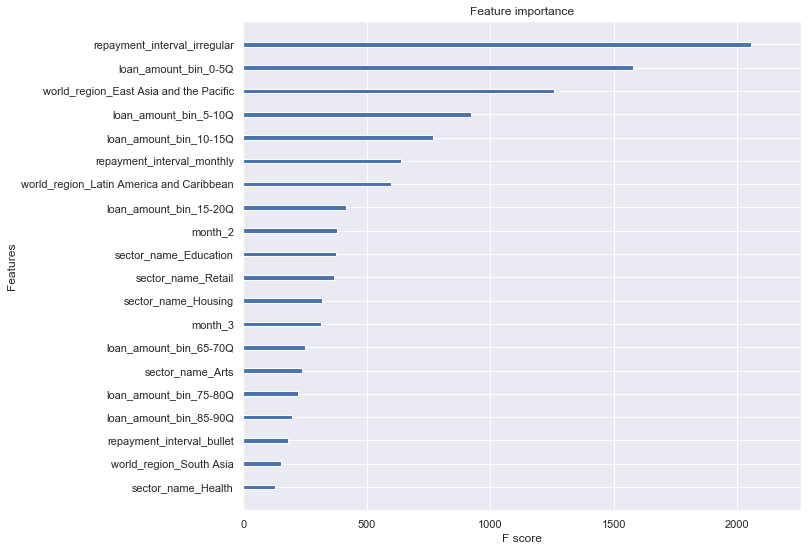

In [70]:
xgb.plot_importance(xg_transf_RW, max_num_features=20, importance_type='gain', show_values=False)
plt.rcParams['figure.figsize'] = [10, 9]
plt.savefig('RW_feature.png', bbox_inches="tight")

#### SHAP reweighing

In [124]:
# this takes a minute or two since we are explaining over 30 thousand samples in a model with over a thousand trees
explainer = shap.TreeExplainer(xg_transf_RW)
shap_values = explainer.shap_values(X_test)

In [125]:
# Base value
preds.mean()

0.3913830902678486

Het berekenen van de SHAP values vertrekt van de mean prediction (voor het baseline model is dit 0.39). Vervolgens vergelijken we de prediction van een bepaalde lening (vb. kans op funded van 0.90) met de mean prediction. Dit verschil bedraagt 0.51. De SHAP values geven vervolgens weer wat de bijdrage/contributie is van een bepaalde feature value (vb. repayment interval = irregular) tot het verschil van 0.51. 

Op deze manier geven zeer positieve SHAP values aan dat de feature value veel bijdraagt tot het voorspellen als funded. Terwijl zeer negatieve SHAP values bijdragen tot het voorspellen als expired.

Onderstaande grafieken plotten de SHAP values voor elke one hot encoded feature afzonderlijk. Dit kan een wat vertekend beeld geven als we vb het belang van de volledige feature 'loan amount' willen weten.

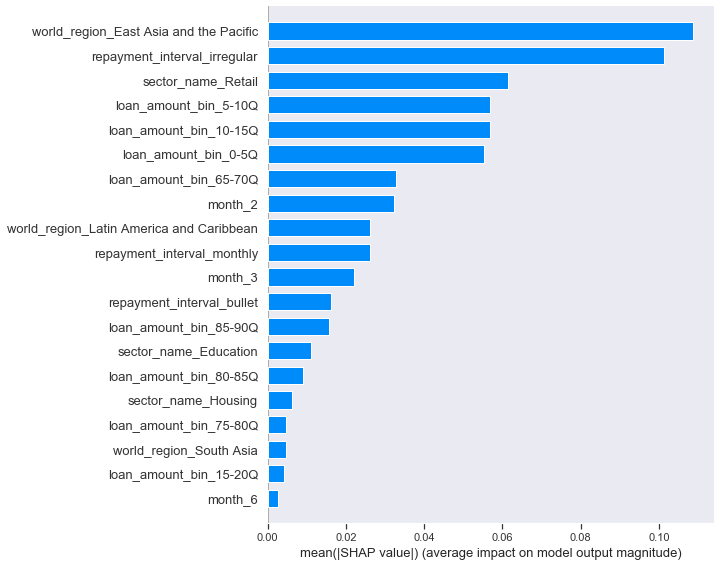

In [77]:
shap.summary_plot(shap_values, X_test, plot_type="bar")

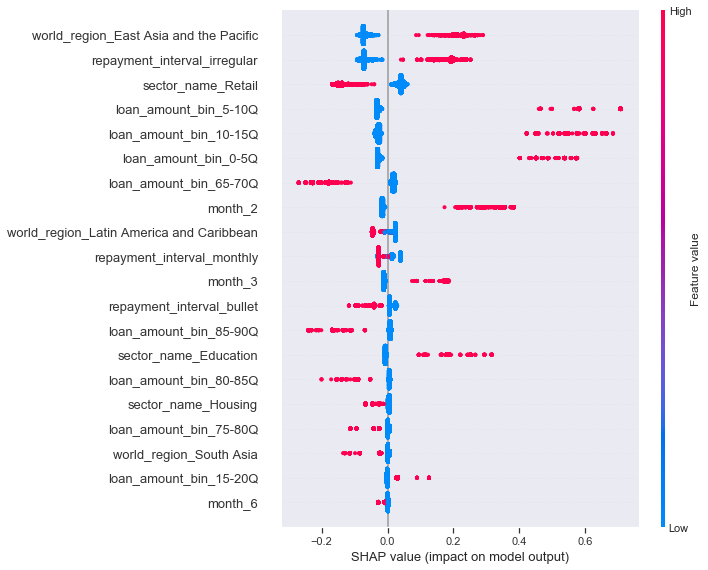

In [78]:
import matplotlib.pyplot as plt
f = plt.figure()
shap.summary_plot(shap_values, X_test)
#f.savefig("summary_plot_RW.png", bbox_inches='tight', dpi=600)

In onderstaande code eerst wat pre-processen om de SHAP values van de one-hot encoded features op te tellen. Zo bekomen we voor elke instance een SHAP value per feature. Deze SHAP value geeft dan de bijdrage tot de prediction van een bepaalde feature(vb. loan amount).

In [126]:
shap_values2 = shap_values.copy()

# group all dummies of a category together
gender_reclassified_female = shap_values2[:,0:1]
sector_df = shap_values2[:,1:15+1]
loan_type_df = shap_values2[:,16:17+1]
world_region_df = shap_values2[:,18:23+1]
repayment_interval_df = shap_values2[:,24:26+1]
month_df = shap_values2[:,27:38+1]
loan_amount_df = shap_values2[:,39:58+1]

# sum SHAP values of each category
gender_female = gender_reclassified_female.sum(axis=1) #Enkel om array flat te maken
sector = sector_df.sum(axis=1)
loan_type = loan_type_df.sum(axis=1)
world_region = world_region_df.sum(axis=1)
repayment_interval = repayment_interval_df.sum(axis=1)
month = month_df.sum(axis=1)
loan_amount = loan_amount_df.sum(axis=1)

# Merge all categories
merge_shap = np.stack([gender_female, sector,
                            loan_type, world_region, repayment_interval,
                            month, loan_amount], axis=-1)
# Check
len(merge_shap)

20982

In [127]:
X_test2 = X_test.copy()

# group all dummies of a category together
gender_reclassified_female = X_test2.iloc[:,0:1]
sector_df2 = X_test2.iloc[:,1:15+1]
loan_type_df2 = X_test2.iloc[:,16:17+1]
world_region_df2 = X_test2.iloc[:,18:23+1]
repayment_interval_df2 = X_test2.iloc[:,24:26+1]
month_df2 = X_test2.iloc[:,27:38+1]
loan_amount_df2 = X_test2.iloc[:,39:58+1]

# Define function to remove prefix for each category
def remove_prefix(prefix):
    return lambda x: x[len(prefix):]

# Remove prefixes and group dummies for each category
sector1 = sector_df2.rename(remove_prefix('sector_name_'), axis='columns')
sector2 = pd.get_dummies(sector1).idxmax(1)
sector = pd.DataFrame(sector2,columns=['sector'])

loan_type1 = loan_type_df2.rename(remove_prefix('loan_type_'), axis='columns')
loan_type2 = pd.get_dummies(loan_type1).idxmax(1)
loan_type = pd.DataFrame(loan_type2,columns=['loan_type'])

world_region1 = world_region_df2.rename(remove_prefix('world_region_'), axis='columns')
world_region2 = pd.get_dummies(world_region1).idxmax(1)
world_region = pd.DataFrame(world_region2,columns=['world_region'])

repayment_interval1 = repayment_interval_df2.rename(remove_prefix('repayment_interval_'), axis='columns')
repayment_interval2 = pd.get_dummies(repayment_interval1).idxmax(1)
repayment_interval = pd.DataFrame(repayment_interval2,columns=['repayment_interval'])

month1 = month_df2.rename(remove_prefix('month_'), axis='columns')
month2 = pd.get_dummies(month1).idxmax(1)
month = pd.DataFrame(month2,columns=['month'])

loan_amount1 = loan_amount_df2.rename(remove_prefix('loan_amount_'), axis='columns')
loan_amount2 = pd.get_dummies(loan_amount1).idxmax(1)
loan_amount = pd.DataFrame(loan_amount2,columns=['loan_amount'])

# Merge all categories
merge_X_test = pd.concat([gender_reclassified_female, sector,
                            loan_type, world_region, repayment_interval,
                            month, loan_amount], axis=1, sort=False)
# Check
len(merge_X_test)


20982

In [128]:
# Check
merge_X_test.head()

gender_reclassified_female       sector   loan_type  \
9159                          1.0  Agriculture  individual   
43565                         0.0  Agriculture  individual   
24819                         1.0     Services  individual   
67453                         0.0  Agriculture  individual   
30751                         1.0       Retail  individual   

                      world_region repayment_interval month loan_amount  
9159     East Asia and the Pacific          irregular     4  bin_15-20Q  
43565  Latin America and Caribbean             bullet     8  bin_85-90Q  
24819    East Asia and the Pacific          irregular     7  bin_15-20Q  
67453  Latin America and Caribbean            monthly    10  bin_45-50Q  
30751  Latin America and Caribbean          irregular     3  bin_60-65Q

In [129]:
# Check
X_test.head()

gender_reclassified_female  sector_name_Agriculture  sector_name_Arts  \
9159                          1.0                      1.0               0.0   
43565                         0.0                      1.0               0.0   
24819                         1.0                      0.0               0.0   
67453                         0.0                      1.0               0.0   
30751                         1.0                      0.0               0.0   

       sector_name_Clothing  sector_name_Construction  sector_name_Education  \
9159                    0.0                       0.0                    0.0   
43565                   0.0                       0.0                    0.0   
24819                   0.0                       0.0                    0.0   
67453                   0.0                       0.0                    0.0   
30751                   0.0                       0.0                    0.0   

       sector_name_Entertainment  sector_name_Food  sector_name_Health  \
9159                         0.0               0.0                 0.0   
43565                        0.0               0.0                 0.0   
24819                        0.0               0.0                 0.0   
67453                        0.0               0.0                 0.0   
30751                        0.0               0.0                 0.0   

       sector_name_Housing  ...  loan_amount_bin_50-55Q  \
9159                   0.0  ...                     0.0   
43565                  0.0  ...                     0.0   
24819                  0.0  ...                     0.0   
67453                  0.0  ...                     0.0   
30751                  0.0  ...                     0.0   

       loan_amount_bin_55-60Q  loan_amount_bin_60-65Q  loan_amount_bin_65-70Q  \
9159                      0.0                     0.0                     0.0   
43565                     0.0                     0.0                     0.0   
24819                     0.0                     0.0                     0.0   
67453                     0.0                     0.0                     0.0   
30751                     0.0                     1.0                     0.0   

       loan_amount_bin_70-75Q  loan_amount_bin_75-80Q  loan_amount_bin_80-85Q  \
9159                      0.0                     0.0                     0.0   
43565                     0.0                     0.0                     0.0   
24819                     0.0                     0.0                     0.0   
67453                     0.0                     0.0                     0.0   
30751                     0.0                     0.0                     0.0   

       loan_amount_bin_85-90Q  loan_amount_bin_90-95Q  loan_amount_bin_95-100Q  
9159                      0.0                     0.0                      0.0  
43565                     1.0                     0.0                      0.0  
24819                     0.0                     0.0                      0.0  
67453                     0.0                     0.0                      0.0  
30751                     0.0                     0.0                      0.0  

[5 rows x 59 columns]

In [130]:
merge_X_test_encoded = merge_X_test.copy()

categorical_names = {}
encoders = {}

# Use Label Encoder for categorical columns (including target column)
for feature in merge_X_test_encoded.columns:
    if feature != 'gender_reclassified_female' and feature !='month':
        le = LabelEncoder()
        le.fit(merge_X_test_encoded[feature])

        merge_X_test_encoded[feature] = le.transform(merge_X_test_encoded[feature])
    
    #categorical_names[feature] = le.classes_
    #encoders[feature] = le

In [131]:
merge_X_test_encoded.head()

gender_reclassified_female  sector  loan_type  world_region  \
9159                          1.0       0          1             1   
43565                         0.0       0          1             3   
24819                         1.0      12          1             1   
67453                         0.0       0          1             3   
30751                         1.0      11          1             3   

       repayment_interval month  loan_amount  
9159                    1     4            2  
43565                   0     8           17  
24819                   1     7            2  
67453                   2    10            8  
30751                   1     3           12

Onderstaande plot toont de importance van elke feature in zijn totaliteit. Wanneer we dit vergelijken met de summary plot waarin de features als one-hot encoded werden voorgesteld, zien we dat de volgorde verandert. Deze plot geeft dan ook een correcter beeld van de feature importance. 

**Vergelijking met baseline:** Gender heeft totaal geen importance meer in het voorspellen van een loan outcome.

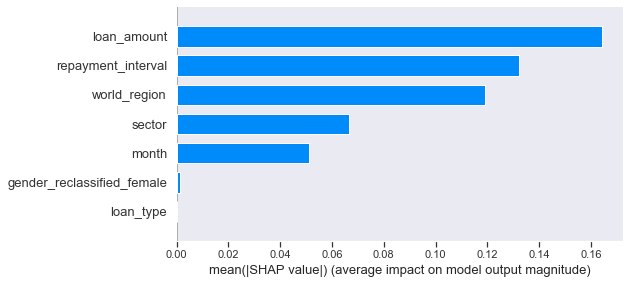

In [132]:
f = plt.figure()
shap.summary_plot(merge_shap, merge_X_test, plot_type="bar")
f.savefig("RW_global.png", bbox_inches='tight')

Vervolgens kunnen we voor de meest belangrijke features de SHAP values plotten voor elke feature value.

**Vergelijking met baseline:** Zeer weinig impact van het Reweighing algoritme op de importance van alle features uitgezonderd gender. Dit is positief want we willen dat ons baseline model enkel gecorrigeerd wordt voor de gender bias.

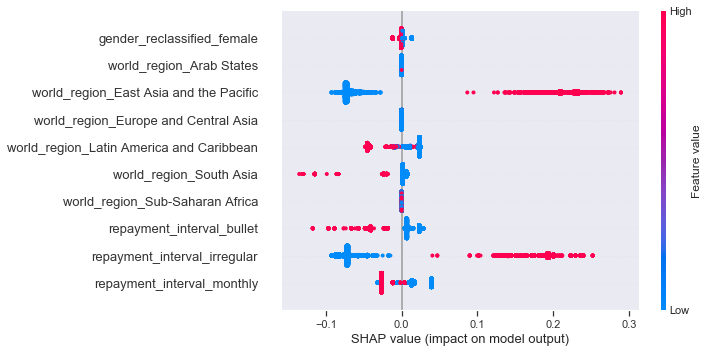

In [133]:
import matplotlib.pyplot as plt
f = plt.figure()
shap.summary_plot(shap_values[:, np.r_[0:1, 18:23+1, 24:26+1]], X_test.iloc[:, np.r_[0:1, 18:23+1, 24:26+1]], sort=False)
f.savefig("RW_summary_part1.png", bbox_inches='tight')

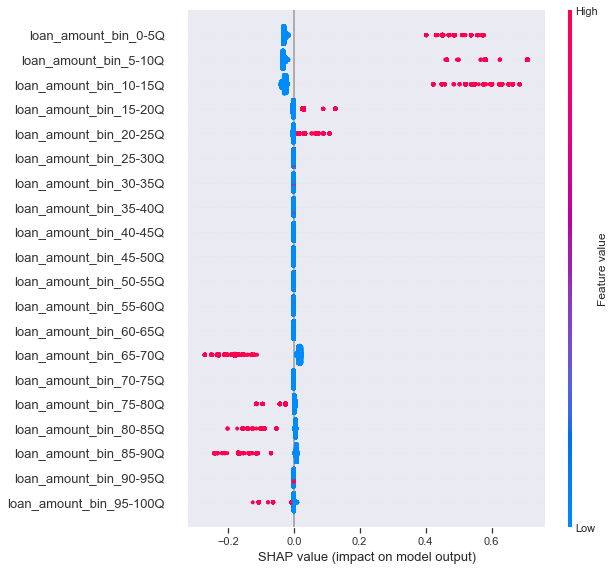

In [134]:
import matplotlib.pyplot as plt
f = plt.figure()
shap.summary_plot(shap_values[:,39:58+1], X_test.iloc[:,39:58+1], sort=False)
f.savefig("RW_summary_part2.png", bbox_inches='tight', dpi=600)

Deze plot is moeilijk te interpreteren (niet gebruiken).

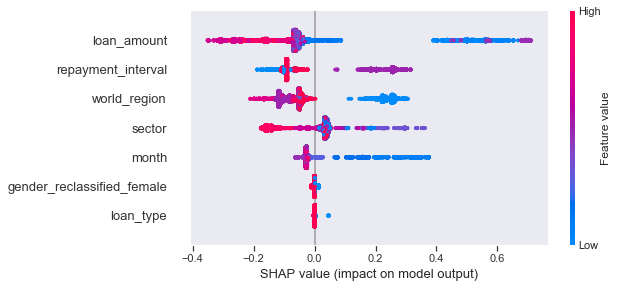

In [88]:
import matplotlib.pyplot as plt
f = plt.figure()
shap.summary_plot(merge_shap, merge_X_test_encoded)
#f.savefig("summary_plot_RW_merge_shap.png", bbox_inches='tight', dpi=600)

Onderstaande plots zijn de dependency plots tussen telkens twee features. Twee belangrijke inzichten uit deze plots **t.o.v. het baseline model** zijn:
   * Gender X sector: Het verschil op basis van geslacht die aanwezig was voor de Education sector is verwijderd.
   * Gender X loan amount: Ook hier geen verband.

Parameter alpha: The transparency of the data points (between 0 and 1). 
This can be useful to show the density of the data points when using a large dataset.

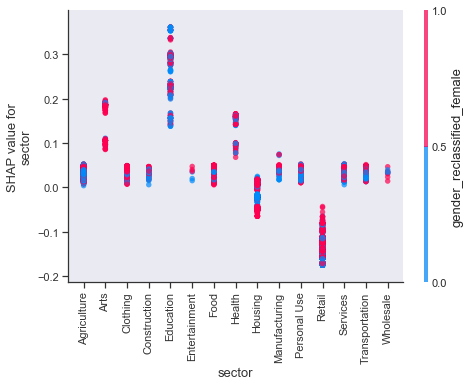

In [136]:
shap.dependence_plot('sector', merge_shap, merge_X_test_encoded, interaction_index="gender_reclassified_female",
                     display_features=merge_X_test, dot_size=30, alpha=0.7, show=False)
f = plt.gcf()
f.savefig("RW_dependency_sector_gender.png", bbox_inches='tight')

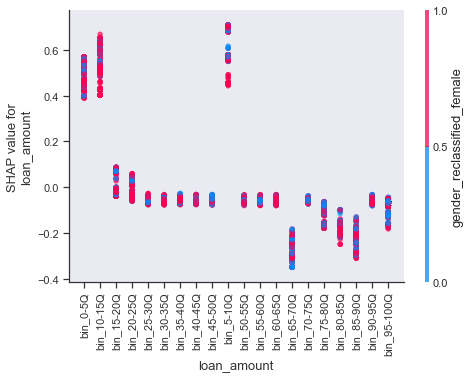

In [90]:
shap.dependence_plot('loan_amount', merge_shap, merge_X_test_encoded, interaction_index="gender_reclassified_female",
                     display_features=merge_X_test, dot_size=30, alpha=0.7)

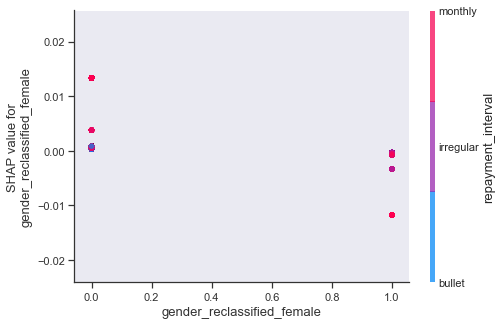

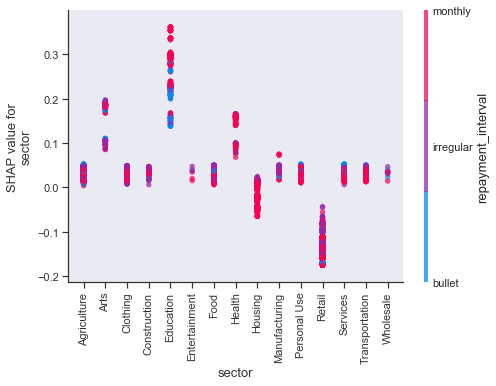

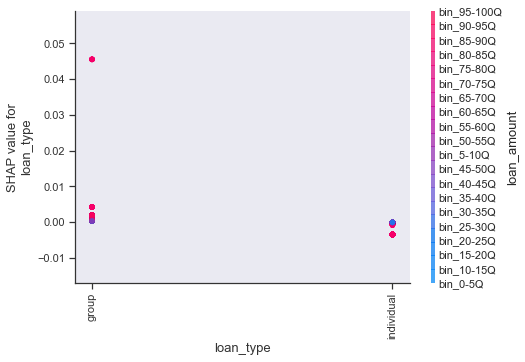

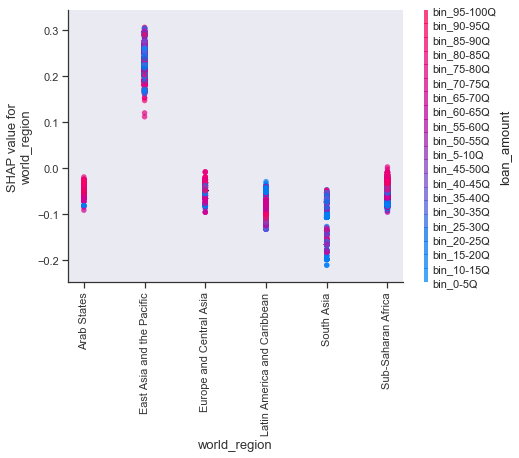

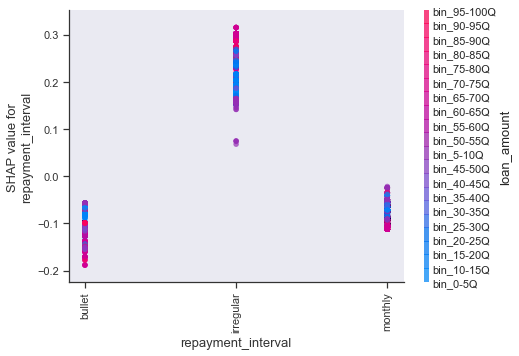

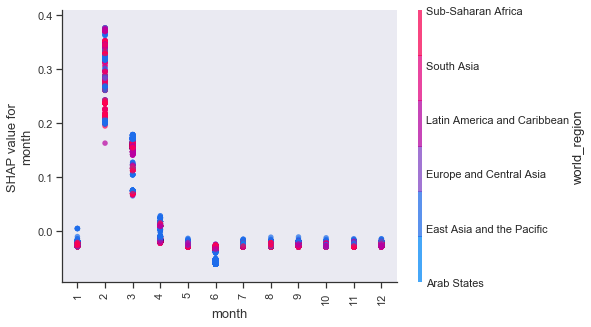

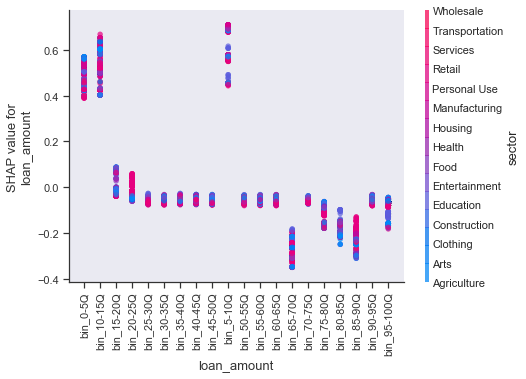

In [91]:
for name in merge_X_test.columns:
    shap.dependence_plot(name, merge_shap, merge_X_test_encoded, display_features=merge_X_test, dot_size=30, alpha=0.7)

### Equality of odds

In [63]:
def confusion_matrix_by_gender(preds, data_orig_test):
    data_orig_test['preds'] = preds
    df_male_preds = data_orig_test['preds'][data_orig_test['gender_reclassified_female'] == 0]
    df_female_preds = data_orig_test['preds'][data_orig_test['gender_reclassified_female'] == 1]
    
    df_male_true = data_orig_test['status'][data_orig_test['gender_reclassified_female'] == 0]
    df_female_true = data_orig_test['status'][data_orig_test['gender_reclassified_female'] == 1]
    
    matrix1 = confusion_matrix(df_male_true, df_male_preds)
    matrix2 = confusion_matrix(df_female_true, df_female_preds)
    
    fig = plt.figure(figsize=(15, 6))
    ax = fig.add_subplot(1, 2, 1)
    
    group_names = ['True Neg','False Pos','False Neg','True Pos']
    group_counts = ["{0:0.0f}".format(value) for value in
                matrix1.flatten()]
    group_percentages = ["{0:.2%}".format(value) for value in
                     matrix1.flatten()/np.sum(matrix1)]
    
    labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in
          zip(group_names,group_counts,group_percentages)]
    
    labels = np.asarray(labels).reshape(2,2)
    
    sns.heatmap(matrix1, annot=labels, fmt='', cmap='Blues', annot_kws={"size": 15})
    
    #sns.heatmap(matrix1, annot=True, cmap='Blues', fmt='g')
    plt.ylabel('True label', fontsize=15)
    plt.xlabel('Predicted label', fontsize=15)
    ax.set_ylim([0,2])
    plt.title('Confusion Matrix men', fontsize=15)

    ax = fig.add_subplot(1, 2, 2)
    
    group_names = ['True Neg','False Pos','False Neg','True Pos']
    group_counts = ["{0:0.0f}".format(value) for value in
                matrix2.flatten()]
    group_percentages = ["{0:.2%}".format(value) for value in
                     matrix2.flatten()/np.sum(matrix2)]
    
    labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in
          zip(group_names,group_counts,group_percentages)]
    
    labels = np.asarray(labels).reshape(2,2)
    
    sns.heatmap(matrix2, annot=labels, fmt='', cmap='Blues', annot_kws={"size": 15})
    #sns.heatmap(matrix2, annot=True, cmap='Blues', fmt='g')
    plt.ylabel('True label', fontsize=15)
    plt.xlabel('Predicted label', fontsize=15)
    ax.set_ylim([0,2])
    plt.title('Confusion Matrix women', fontsize=15)

In [64]:
df = data_orig_sex_train.convert_to_dataframe(de_dummy_code=False, sep='=', set_category=True)
df_train = df[0].copy()
df1 = data_orig_sex_test.convert_to_dataframe(de_dummy_code=False, sep='=', set_category=True)
df_test = df1[0].copy()
xg_orig = xgb.XGBClassifier(objective ='binary:logistic', colsample_bytree = 0.3, learning_rate = 0.1,
                max_depth = 4, alpha = 10, n_estimators = 10)

y_train= df_train['status']
X_train= df_train.drop('status',axis=1)
xg_orig = xg_orig.fit(X_train,y_train)

y_test= df_test['status']
X_test= df_test.drop('status',axis=1)

Before equality of odds

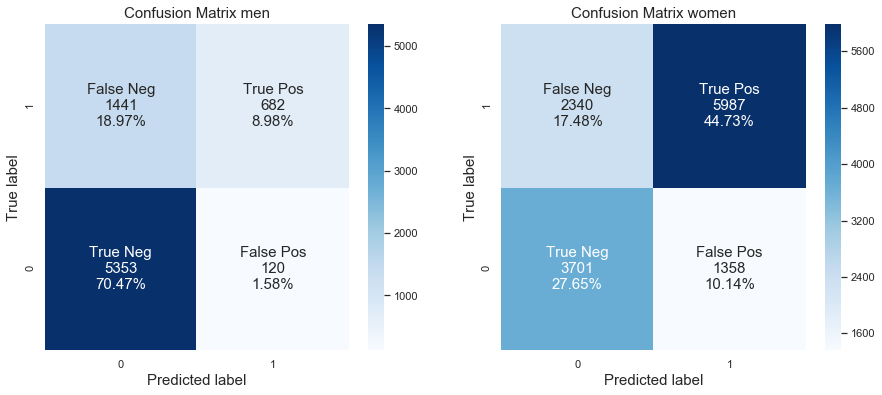

In [65]:
preds = xg_orig.predict(X_test)
confusion_matrix_by_gender(list(preds), df_test)

After equality of odds

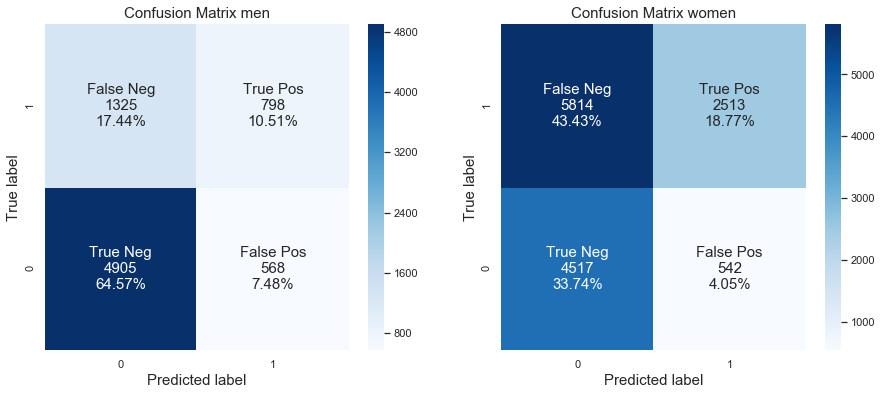

In [68]:
confusion_matrix_by_gender(list(preds_EOPP), df_test)

### LFR

In [137]:
#privileged_groups, unprivileged_groups = get_attributes(data_orig_train, selected_attr=['gender_reclassified'])
privileged_groups = [{'gender_reclassified_female': 1}]
unprivileged_groups = [{'gender_reclassified_female': 0}]
t0 = time()

LFR_model = LFR(unprivileged_groups=unprivileged_groups, privileged_groups=privileged_groups,
                Ax=1, Ay=0.21, Az=1, k=5, print_interval=250, verbose=1, seed=42)
# LFR.fit(data_orig_train)
data_transf_train = LFR_model.fit_transform(data_orig_train)
data_transf_test = LFR_model.transform(data_orig_test)

df2 = data_transf_train.convert_to_dataframe(de_dummy_code=False, sep='=', set_category=True)
df_train_transf = df2[0].copy()
df3 = data_orig_test.convert_to_dataframe(de_dummy_code=False, sep='=', set_category=True)
df_test_orig = df3[0].copy()
df4 = data_transf_test.convert_to_dataframe(de_dummy_code=False, sep='=', set_category=True)
df_test_transf = df4[0].copy()

xg_orig = xgb.XGBClassifier(objective ='binary:logistic', colsample_bytree = 0.3, learning_rate = 0.1,
                max_depth = 4, alpha = 10, n_estimators = 10)

y_train= df_train_transf['status']
X_train= df_train_transf.drop('status',axis=1)
instance_weights = df2[1]['instance_weights'].copy()
xg_transf_LFR = xg_orig.fit(X_train,y_train, sample_weight=instance_weights)

y_test= df_test_orig['status']
X_test= df_test_transf.drop('status',axis=1)
probs = xg_transf_LFR.predict_proba(X_test)
preds = xg_transf_LFR.predict(X_test)

from sklearn.metrics import accuracy_score
# evaluate predictions
accuracy = accuracy_score(y_test, preds)
print("Accuracy: %.2f%%" % (accuracy * 100.0))

5250 752921.2403150229
5500 570615.7304577068
5750 570615.74554648
6000 318041.01620037394
6250 318040.99992609455
6500 297413.8655561274
6750 239676.30855255525
7000 239676.30298114882
7250 223988.81782073548
7500 223988.84786783392
7750 220479.8437938102
8000 216112.18615511846
8250 216112.1885934564
8500 210026.91097075754
8750 210026.91671919115
9000 203513.54431598185
9250 191407.40155113523
9500 191407.39418891713
9750 189180.1602342887
10000 189180.16332578703
Accuracy: 62.65%


**Decision tree**

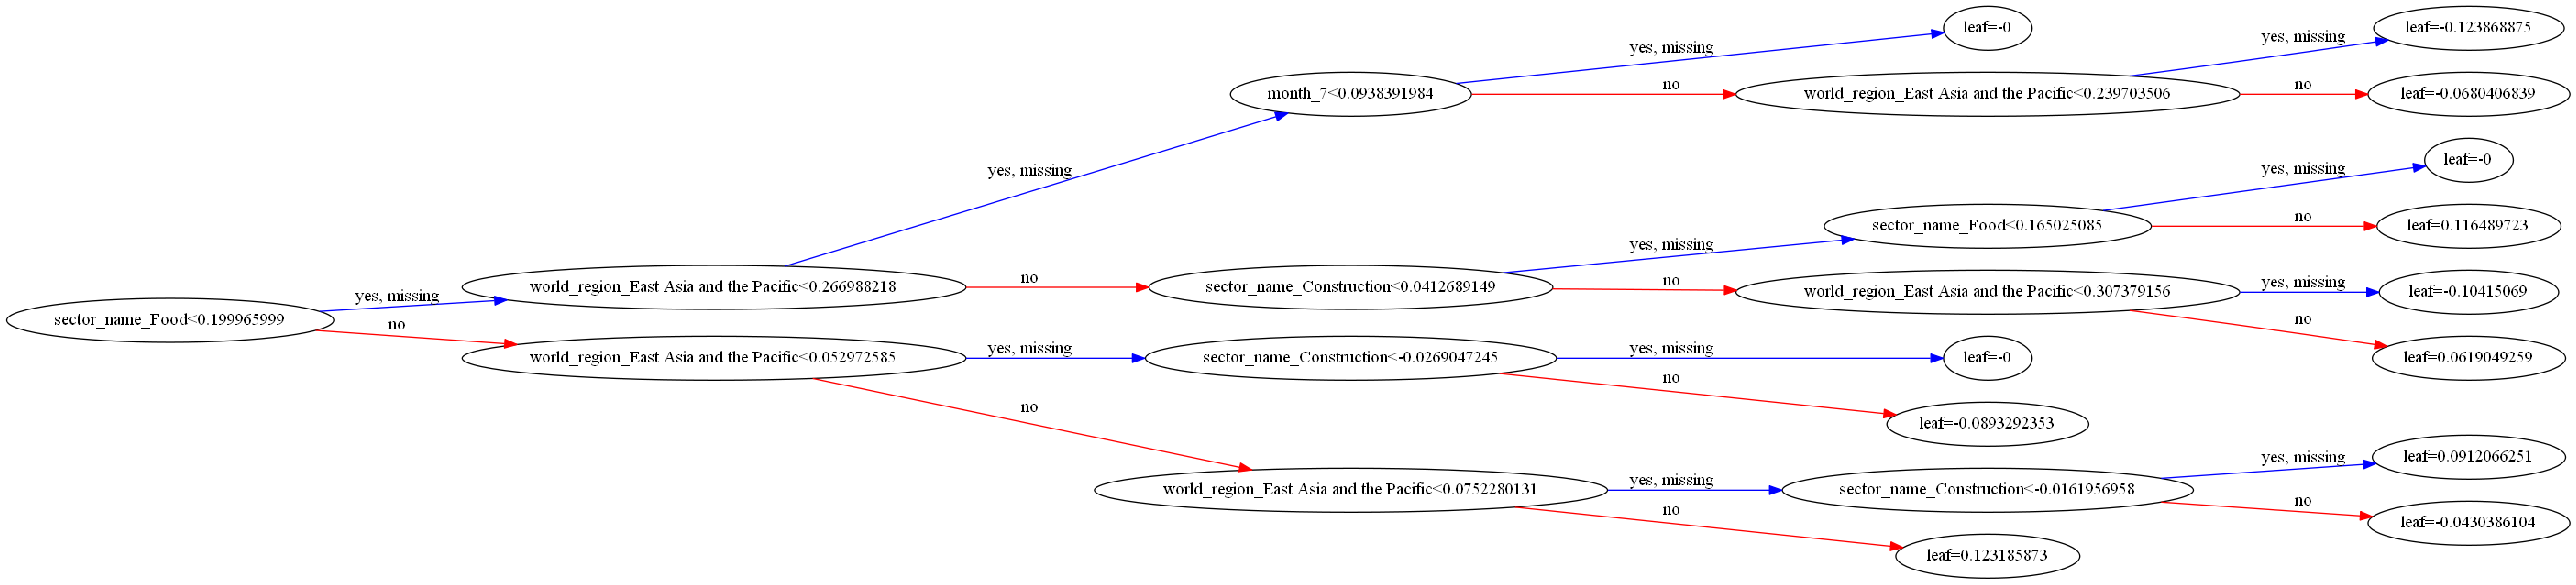

In [72]:
# Plot decision tree
xgb.plot_tree(xg_transf_LFR,num_trees=9, rankdir='LR')
#plt.rcParams['figure.figsize'] = [500, 100]
#plt.show()
fig = plt.gcf()
fig.set_size_inches(200, 200)
fig.savefig('LFR_tree.png')

In [73]:
cNodeParams = {'shape':'box',
               'style':'filled,rounded',
               'fillcolor':'#78bceb',
               'fontsize':'22'
              }
lNodeParams = {'shape':'box',
               'style':'filled',
               'fillcolor':'#e48038',
               'fontsize':'22'
              }
gvz = xgb.to_graphviz(xg_transf_LFR, num_trees=9, rankdir='LR', yes_color=None, no_color=None, 
                      condition_node_params=cNodeParams, leaf_node_params=lNodeParams,**{'size':str(10)})
print(gvz.source)

digraph {
    graph [ rankdir=TB ]
    graph [ rankdir="LR" ]
    graph [ size="10" ]

    0 [ label="sector_name_Food<0.199965999" fillcolor="#78bceb" fontsize="22" shape="box" style="filled,rounded" ]
    0 -> 1 [label="yes, missing" color="#0000FF"]
    0 -> 2 [label="no" color="#FF0000"]

    1 [ label="world_region_East Asia and the Pacific<0.266988218" fillcolor="#78bceb" fontsize="22" shape="box" style="filled,rounded" ]
    1 -> 3 [label="yes, missing" color="#0000FF"]
    1 -> 4 [label="no" color="#FF0000"]

    3 [ label="month_7<0.0938391984" fillcolor="#78bceb" fontsize="22" shape="box" style="filled,rounded" ]
    3 -> 7 [label="yes, missing" color="#0000FF"]
    3 -> 8 [label="no" color="#FF0000"]

    7 [ label="leaf=-0" fillcolor="#e48038" fontsize="22" shape="box" style="filled" ]

    8 [ label="world_region_East Asia and the Pacific<0.239703506" fillcolor="#78bceb" fontsize="22" shape="box" style="filled,rounded" ]
    8 -> 15 [label="yes, missing" color="#0000FF"]
 

**Feature importance**

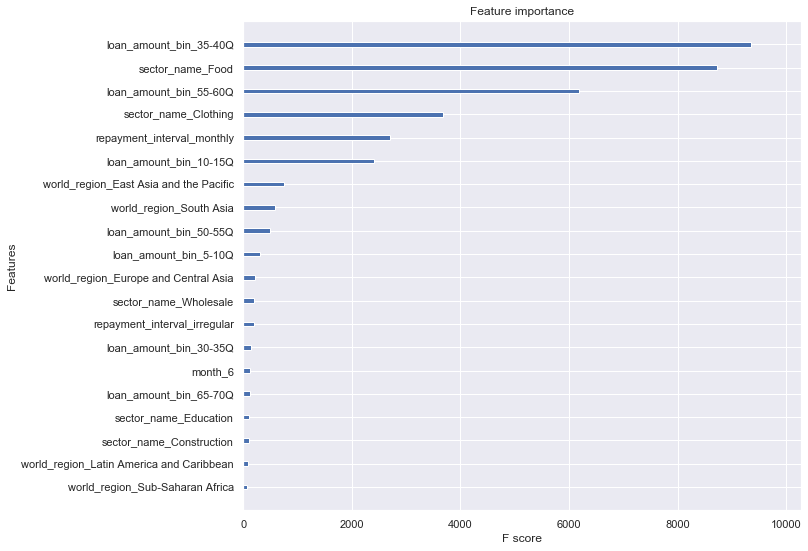

In [74]:
xgb.plot_importance(xg_transf_LFR, max_num_features=20, importance_type='gain', show_values=False)
plt.rcParams['figure.figsize'] = [10, 9]
plt.savefig('LFR_feature.png', bbox_inches="tight")

#### SHAP LFR

In [140]:
# this takes a minute or two since we are explaining over 30 thousand samples in a model with over a thousand trees
explainer = shap.TreeExplainer(xg_transf_LFR)
shap_values = explainer.shap_values(X_test)

In [141]:
# Base value
preds.mean()

0.5053855685825946

Het berekenen van de SHAP values vertrekt van de mean prediction (voor het baseline model is dit 0.39). Vervolgens vergelijken we de prediction van een bepaalde lening (vb. kans op funded van 0.90) met de mean prediction. Dit verschil bedraagt 0.51. De SHAP values geven vervolgens weer wat de bijdrage/contributie is van een bepaalde feature value (vb. repayment interval = irregular) tot het verschil van 0.51. 

Op deze manier geven zeer positieve SHAP values aan dat de feature value veel bijdraagt tot het voorspellen als funded. Terwijl zeer negatieve SHAP values bijdragen tot het voorspellen als expired.

Onderstaande grafieken plotten de SHAP values voor elke one hot encoded feature afzonderlijk. Dit kan een wat vertekend beeld geven als we vb het belang van de volledige feature 'loan amount' willen weten.

**Probleem 1 van LFR**: Bij het LFR algoritme kunnen we de one-hot encoded features niet terug samenbrengen naar de oorspronkelijke features aangezien elke one-hot encoded feature nu feature values heeft die continue zijn. 

**Probleem 2 van LFR**: Doordat de feature values nu continue zijn kunnen we de features ook niet meer interpreteren. 

Hierdoor kunnen we ook slechts onderstaande plots maken waarbij we dus enkel de one-hot encoded features gebruiken.

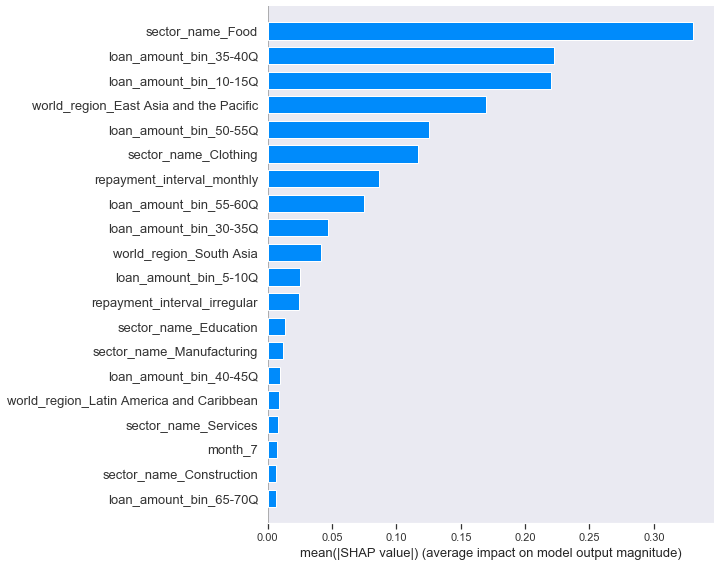

In [142]:
f = plt.figure()
shap.summary_plot(shap_values, X_test, plot_type="bar")
f.savefig("LFR_global.png", bbox_inches='tight')

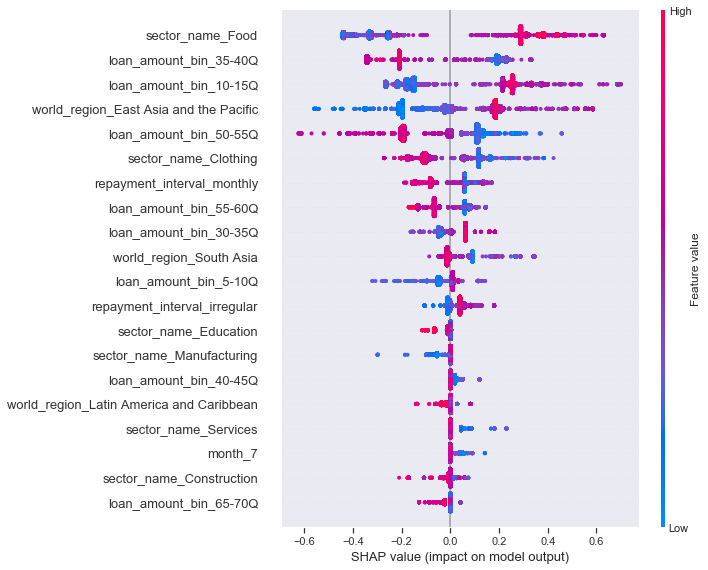

In [143]:
import matplotlib.pyplot as plt
f = plt.figure()
shap.summary_plot(shap_values, X_test)
f.savefig("LFR_summary.png", bbox_inches='tight')

De plots tonen wel aan dat gender niet meer gebruikt wordt in het model.